From Megan's notes at: https://uoregonctn.atlassian.net/wiki/spaces/DE/pages/1744076802/RTFS+and+Stop+Signal+Distress

### The plan

Neural activity of the go trial immediately following a failed stop compared to (all/previous trial) go trials following a correct stop. For each subject, run the following to get an individual difference measure.  Here is a univariate version, that is less sensitive. 

Step 1: Find a mask from dACC

Step 2: What if you do a machine learning classifier or similarity/dissimilarity matrix within the voxels from step 1 (< more direct measure) 

Step 3: Obtain the correlation between the post-failure versus post-correct, then regress this on FFQ.

Step 4: Repeat for emotional regulation 

Work with Rob or Dasha to look at Individual difference measure #2, a post no error minus pre no error comparison as a control.  (OR post error versus the next post correct)  

### Using existing betas

1. load the betas
2. do behavioral analysis to identify post-failure and post-current events
3. Take the correlations between each.


### Using a beta-average approach

1. Do behavioral analyses to identify post-failure and post-current events
2. From this, create a beta series
3. Do extraction.
4. Run correlation.

Although we have to work a bit harder to get it, I'm going to use the second method because I think it'll be more reliable.

We modify multiconds.py to do the job.

This file takes content from regress_on_nogo_go_pattern.

#### Setup

In [1]:
import sys
import os
import pandas as pd
from os import path

import pickle
from IPython.core.display import display, HTML, Markdown

sys.path.append(os.path.abspath("../../ml/"))

from apply_loocv_and_save import *
from dev_wtp_io_utils import *
import gc
import nibabel as nib

nonbids_data_path = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/"
ml_data_folderpath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml"
train_test_markers_filepath = ml_data_folderpath + "/train_test_markers_20210601T183243.csv"
test_train_df = pd.read_csv(train_test_markers_filepath)

all_sst_events= pd.read_csv(ml_data_folderpath +"/SST/" + "all_sst_events.csv")


dataset_name = 'posterror_conditions'

from nilearn.decoding import DecoderRegressor, Decoder

script_path = '/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml'
# HRF 2s

#get a PFC mask
#pfc_mask = create_mask_from_images(get_pfc_image_filepaths(ml_data_folderpath + "/"),threshold=10)
#get the masks we want




python initialized for apply_loocv_and_save


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


cpus available; cpus to use:
28 25
28


In [2]:
def condition_resp_trans_func(X):
    return(X.condition_label)

In [3]:

def decoderConstructor(*args, **kwargs):
    return(Decoder(scoring='accuracy',verbose=0, *args, **kwargs))

In [4]:
background_img = nlt.Brain_Data('/projects/sanlab/shared/spm12/canonical/MNI152_T1_1mm_brain.nii').to_nifti()

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/image/resampling.py:531: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


In [5]:
neurosynth_emo_reg_mask = nlt.Brain_Data(ml_data_folderpath + '/masks/emotion regulation_association-test_z_FDR_0.01.nii.gz').threshold(binarize=True).to_nifti()
neurosynth_error_mask = nlt.Brain_Data(ml_data_folderpath + '/masks/error_association-test_z_FDR_0.01.nii.gz').threshold(binarize=True).to_nifti()
accmask = nlt.Brain_Data(ml_data_folderpath + '/masks/harvardoxford-cortical_prob_Cingulate Gyrus, anterior division.nii.gz').threshold(binarize=True,upper=25).to_nifti()

In [6]:
def get_bd_contrast(bd):
    bd.X.reset_index(inplace=True,drop=True)

    bd_contrast = None
    for subject in np.unique(bd.X.subject):
        print(subject,end=", ")
        #get all the indices of images with this subject
        #ensure that we have exactly two images for this subject
        subj_indices = bd.X.index[bd.X.subject==subject]
        if len(subj_indices)!=2:
            raise Exception("should be precisely two images for each subject. there wasn't. look into this.")

        subject_bd = bd[subj_indices]
        condition_0_image = subject_bd[subject_bd.X.condition_label=="CorrectGoFollowingCorrectStop"]
        condition_1_image = subject_bd[subject_bd.X.condition_label=="CorrectGoFollowingFailedStop"]

        subject_failed_stop_minus_correct_stop = condition_1_image - condition_0_image
        #remove items that aren't relevant for the contrast.
        subject_failed_stop_minus_correct_stop.X.drop(['condition_index','condition_label','raw_beta_description','beta'],axis=1,inplace=True)

        if bd_contrast is None:
            bd_contrast = subject_failed_stop_minus_correct_stop
        else:
            bd_contrast = bd_contrast.append(subject_failed_stop_minus_correct_stop)


    bd_contrast.X.reset_index(inplace=True,drop=True)
    return(bd_contrast)

### emotion regulation mask

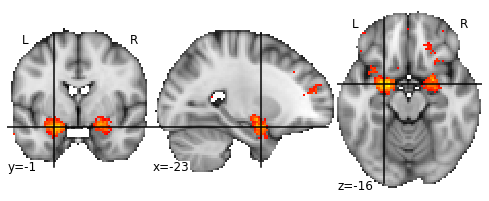

In [7]:
neurosynth_emo_reg = nlt.Brain_Data(ml_data_folderpath + '/masks/emotion regulation_association-test_z_FDR_0.01.nii.gz').to_nifti()

plotting.plot_img(
    neurosynth_emo_reg,
    threshold='auto',
    cmap='autumn',
    
    bg_img=background_img)

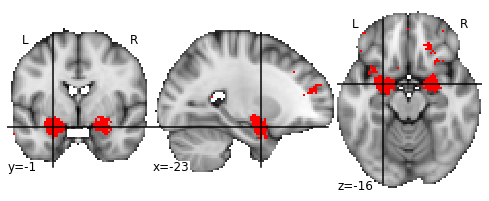

In [8]:
neurosynth_emo_reg_mask = nlt.Brain_Data(ml_data_folderpath + '/masks/emotion regulation_association-test_z_FDR_0.01.nii.gz').threshold(binarize=True).to_nifti()

plotting.plot_img(
    neurosynth_emo_reg_mask,
    threshold='auto',
    cmap='autumn',
    
    bg_img=background_img)

In [9]:
def decoderConstructor(*args, **kwargs):
    return(Decoder(scoring='accuracy',verbose=0, *args, **kwargs))

In [10]:
from nilearn import surface
from nilearn import datasets
from nilearn import plotting

In [11]:
from nilearn import surface
from nilearn import datasets
from nilearn import plotting
from matplotlib import pyplot
from scipy.stats import pearsonr


## emotional regulation analysis

In [12]:
dataset_mask_label = 'neurosynth_emo_reg_mask'
relevant_mask = neurosynth_emo_reg_mask
results_filepath=ml_data_folderpath + "/SST/train_test_res_nozscore_" + dataset_name + "_84subs_twoclasses_" + dataset_mask_label +".pkl"
brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_posterror_conditions_84subs_correct_cond.pkl'


/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_res_nozscore_posterror_conditions_84subs_twoclasses_neurosynth_emo_reg_mask.pkl
0.654320987654321


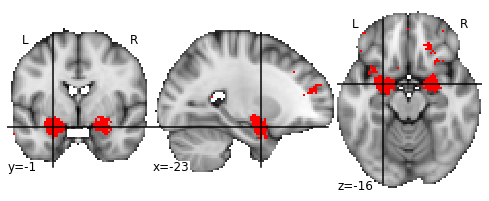

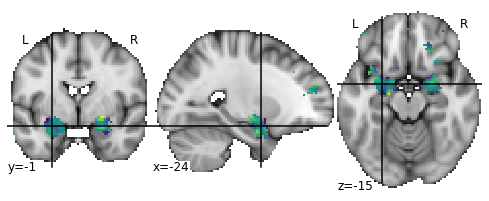

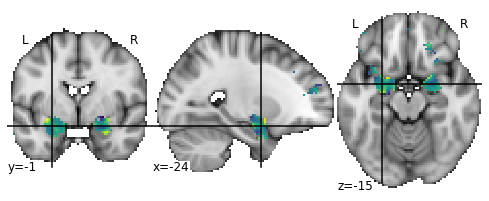

In [13]:
plotting.plot_img(
    relevant_mask,
    threshold='auto',
    cmap='autumn',
    bg_img=background_img)


print(results_filepath)
results=pickle.load(open(results_filepath,'rb'))

print(np.mean(results[0]))

PostCorrect_ns=results[3]['CorrectGoFollowingCorrectStop']
#display(Markdown("### CorrectGoFollowingCorrectStop"))
plotting.plot_img(PostCorrect_ns,threshold='auto',bg_img=background_img)

PostError_ns=results[3]['CorrectGoFollowingFailedStop']
#display(Markdown("### CorrectGoFollowingFailedStop"))
plotting.plot_img(PostError_ns,threshold='auto',bg_img=background_img)

In [14]:

# def plot_stat_maps(PostError_ns,PostCorrect_ns):
#     plotting.plot_stat_map(PostError_ns, display_mode='z',
#                            cut_coords=range(20, 61, 10), title='Slices',cmap='RdBu')

#     plotting.plot_stat_map(PostCorrect_ns, display_mode='z',
#                            cut_coords=range(20, 61, 10), title='Slices',cmap='RdBu')
#     pyplot.show()




# def get_bd(brain_data_filepath,PostError_ns,PostCorrect_ns,relevant_mask):
#     bd=pickle.load(open(brain_data_filepath,'rb'))
    
#     if relevant_mask is None:
#         relevant_mask = nlt.Brain_Data(PostError_ns).mask
#     print("applying mask")
#     bd_to_measure = bd.apply_mask(relevant_mask)
#     #bd_PostError=bd[bd.X.condition_label=="CorrectGoFollowingFailedStop"]

#     #bd.X.condition_label.value_counts()

#     print("getting similarity 1")
#     bd.X['PostError_similarity'] = (bd_to_measure.similarity(PostError_ns))
#     print("getting similarity 2")
#     bd.X['PostCorrect_similarity'] = (bd_to_measure.similarity(PostCorrect_ns))

#     return(bd)

In [15]:
from analyze_results import plot_stat_maps, get_bd

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_res_nozscore_posterror_conditions_84subs_twoclasses_neurosynth_emo_reg_mask.pkl
plotting signatures


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:341: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


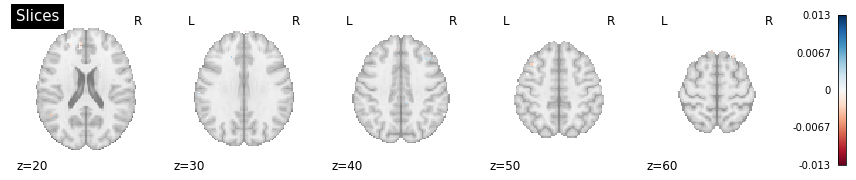

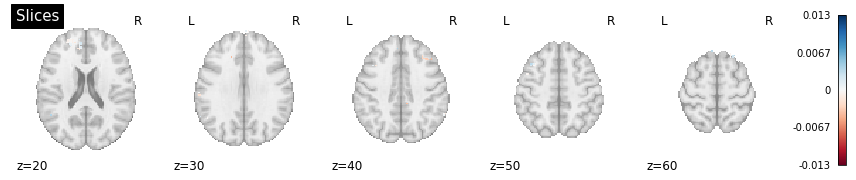

loading data
applying mask
getting similarity 1
getting similarity 2


In [16]:
print(results_filepath,flush=True)

print("plotting signatures")
plot_stat_maps(PostError_ns,PostCorrect_ns)
print("loading data")
bd=get_bd(brain_data_filepath,PostError_ns,PostCorrect_ns,relevant_mask)



creating histograms


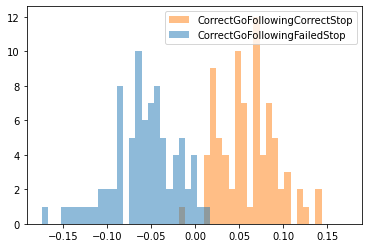

In [17]:
from analyze_results import create_histogram
# def create_histogram(bd):
#     print("creating histograms")
#     bd_to_plot = bd.X[['condition_label','PostError_similarity','subject']].pivot(index='subject',columns='condition_label',values='PostError_similarity').reset_index()
#     bins=np.linspace(-0.2,0.3,51) #create histogram bins
#     pyplot.hist(
#         bd_to_plot[['CorrectGoFollowingCorrectStop','CorrectGoFollowingFailedStop']]#.to_numpy()
#         ,bins=bins
#         ,alpha=0.5,histtype='stepfilled',label=['CorrectGoFollowingCorrectStop','CorrectGoFollowingFailedStop'])
#     pyplot.legend(prop={'size': 10})
#     pyplot.show();


#     display(HTML(pd.DataFrame(bd.X.groupby('condition_label').agg({
#         'PostError_similarity':"mean",
#         'PostCorrect_similarity':"mean"})).to_html()))
    

create_histogram(bd)

In [20]:
from analyze_results import *#, outlier_detection_median_sd
# def get_ind_div_for_pes_combined(bd):

#     pes_data = pd.read_csv(ml_data_folderpath + "/post_error_slowing.csv",index_col=0)

#     individual_differences = pd.read_csv(ml_data_folderpath + "/data_by_ppt.csv")
#     individual_differences = individual_differences.rename(columns={'SID':'subject'})
#     individual_differences['wave']=1
#     #individual_differences['wave'] = individual_differences['wave'].astype(object) # for compatibility with the wave column in the dataset

#     individual_differences = pd.merge(individual_differences,pes_data,how='outer',left_on='subject',right_on='subid')

#     subject_pc_neural_performance = bd.X.loc[bd.X.condition_label=='CorrectGoFollowingCorrectStop',['subject','PostError_similarity','PostCorrect_similarity']]
#     subject_pe_neural_performance = bd.X.loc[bd.X.condition_label=='CorrectGoFollowingFailedStop',['subject','PostError_similarity','PostCorrect_similarity']]

#     subject_pc_neural_performance.columns = ['PC_trials_' + col for col in subject_pc_neural_performance.columns]
#     subject_pe_neural_performance.columns = ['PE_trials_' + col for col in subject_pe_neural_performance.columns]
#     subject_neural_performance = subject_pc_neural_performance.merge(subject_pe_neural_performance,left_on='PC_trials_subject',right_on='PE_trials_subject',how='outer')
#     subject_neural_performance =subject_neural_performance.rename(columns = {'PC_trials_subject':'subject'})

#     ind_div_combined = subject_neural_performance.merge(individual_differences,left_on='subject',right_on='subject',how='left')
    
#     return(ind_div_combined)

# https://www.sciencedirect.com/topics/mathematics/declared-outlier

ind_div_combined = get_ind_div_for_pes_combined(bd,ml_data_folderpath)



ind_div_combined = remove_selected_outliers_rtfs_study(ind_div_combined,show_plot=False)



Index(['subid', 'pes_mean_limited'], dtype='object')
Index(['subid', 'PECG_mean', 'PCCG_mean', 'PostErrorSlowW1'], dtype='object')


In [21]:
pepc_contrast_data = pd.read_csv(ml_data_folderpath + "/post_error_slowing_simple_approach.csv",index_col=0)

In [22]:
pepc_contrast_data

subid  PECG_mean  PCCG_mean  PostErrorSlowW1
1    DEV004   0.580222   0.521924         0.058297
2    DEV005   0.514085   0.486355         0.027730
3    DEV006   0.704284   0.598624         0.105660
4    DEV007   0.648019   0.570279         0.077740
5    DEV008   0.495985   0.485830         0.010156
..      ...        ...        ...              ...
137  DEV151   0.581383   0.497986         0.083396
138  DEV152   0.809728   0.830340        -0.020612
139  DEV153   0.702864   0.723630        -0.020767
140  DEV154   0.625594   0.652066        -0.026472
141  DEV155   0.481491   0.479211         0.002279

[141 rows x 4 columns]

In [23]:
from analyze_results import visualize_corr

### PE_trials_PostError_similarity

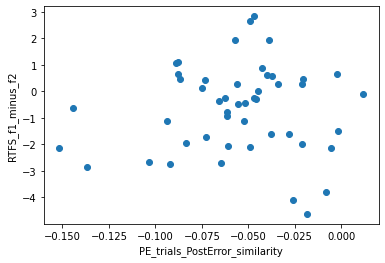

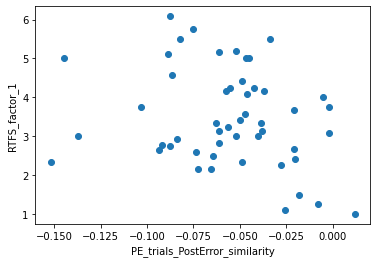

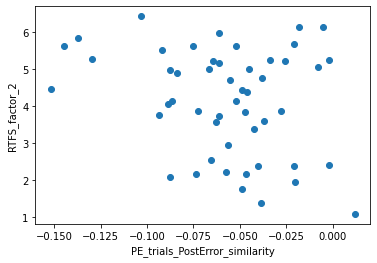

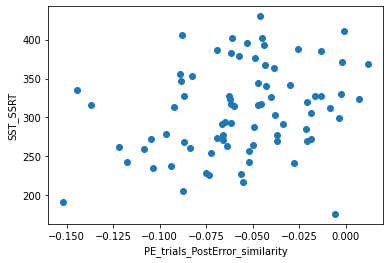

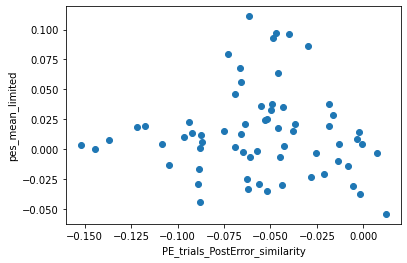

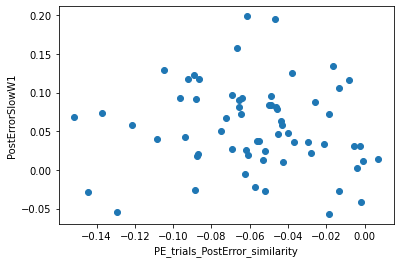

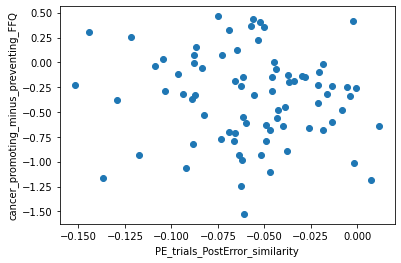

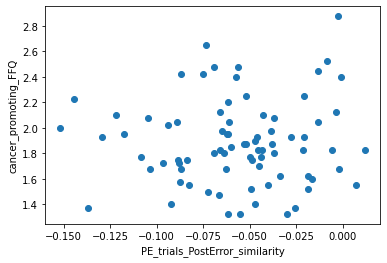

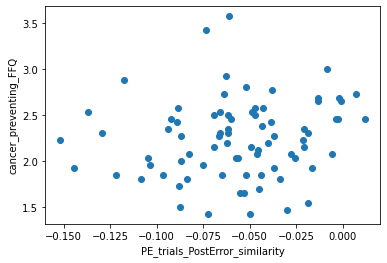

### PC_trials_PostCorrect_similarity

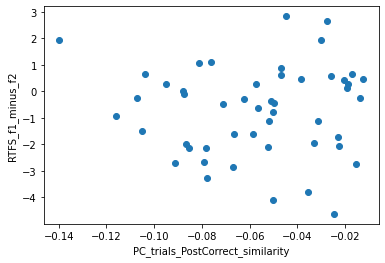

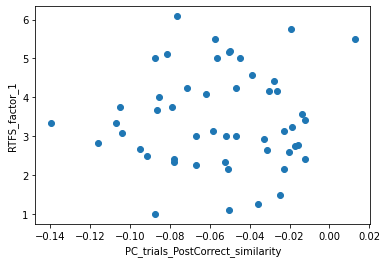

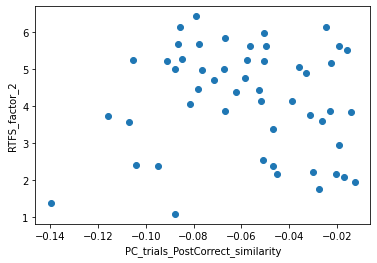

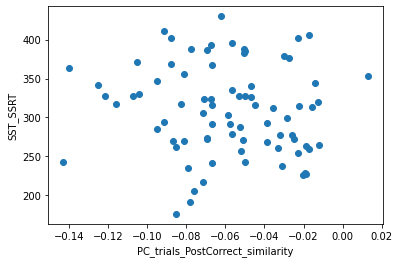

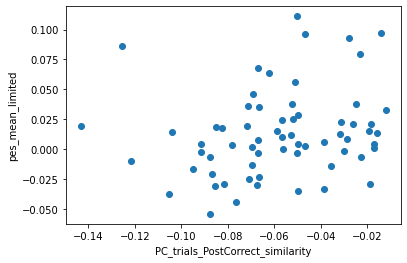

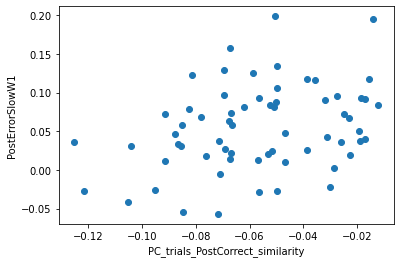

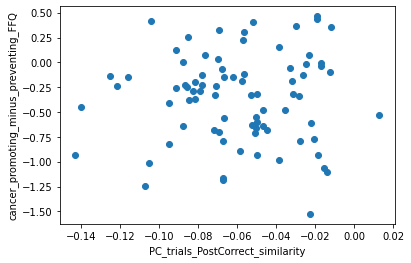

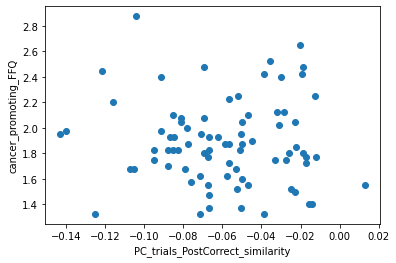

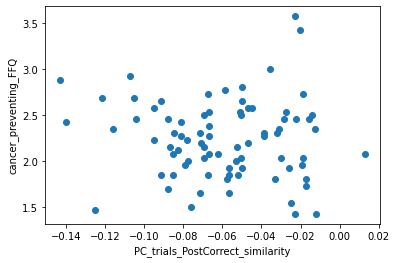

In [24]:
for neural_var in ['PE_trials_PostError_similarity','PC_trials_PostCorrect_similarity']:
    display(Markdown("### " + neural_var))
    for correlate in [
        'RTFS_f1_minus_f2','RTFS_factor_1','RTFS_factor_2',
        'SST_SSRT','pes_mean_limited','PostErrorSlowW1','cancer_promoting_minus_preventing_FFQ',
        'cancer_promoting_FFQ','cancer_preventing_FFQ']:
        visualize_corr(neural_var,correlate,ind_div_combined)

## error analysis

In [25]:
dataset_mask_label = 'neurosynth_error_mask'
relevant_mask = neurosynth_error_mask
results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_84subs_twoclasses_" + dataset_mask_label +".pkl"
brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_posterror_conditions_84subs_correct_cond.pkl'


/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_error_mask.pkl
0.7283950617283951


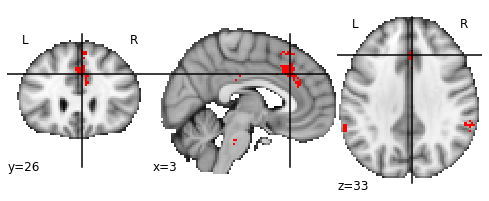

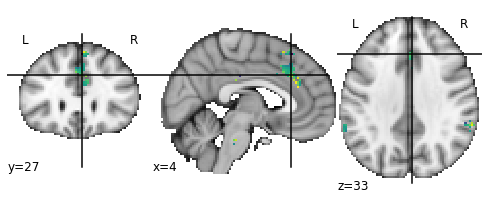

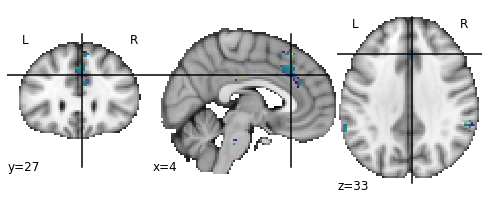

In [26]:
plotting.plot_img(
    relevant_mask,
    threshold='auto',
    cmap='autumn',
    bg_img=background_img)


print(results_filepath)
results=pickle.load(open(results_filepath,'rb'))

print(np.mean(results[0]))

PostCorrect_ns=results[3]['CorrectGoFollowingCorrectStop']
#display(Markdown("### CorrectGoFollowingCorrectStop"))
plotting.plot_img(PostCorrect_ns,threshold='auto',bg_img=background_img)

PostError_ns=results[3]['CorrectGoFollowingFailedStop']
#display(Markdown("### CorrectGoFollowingFailedStop"))
plotting.plot_img(PostError_ns,threshold='auto',bg_img=background_img)

In [27]:
sum(np.isnan(ind_div_combined.PE_trials_PostError_similarity))

1

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_error_mask.pkl
plotting signatures


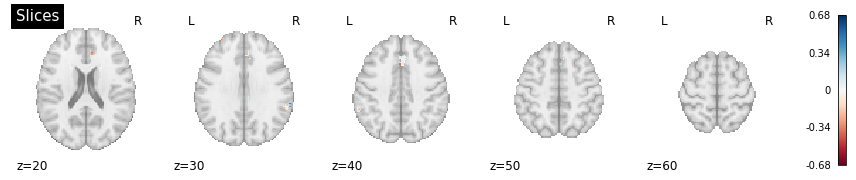

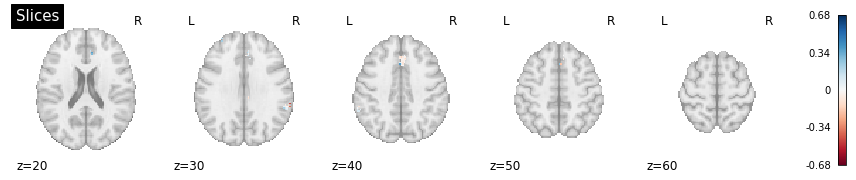

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


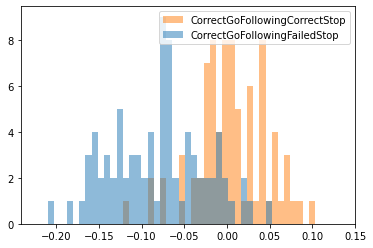

Index(['subid', 'pes_mean_limited'], dtype='object')
Index(['subid', 'PECG_mean', 'PCCG_mean', 'PostErrorSlowW1'], dtype='object')


### PE_trials_PostError_similarity

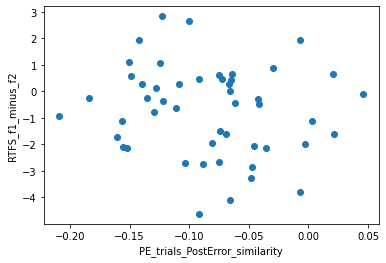

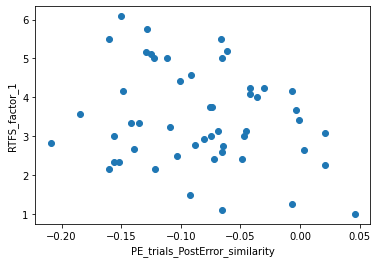

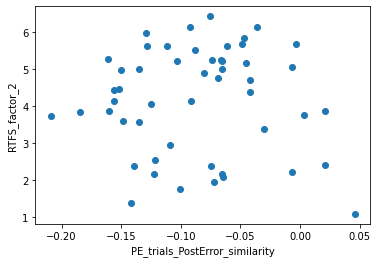

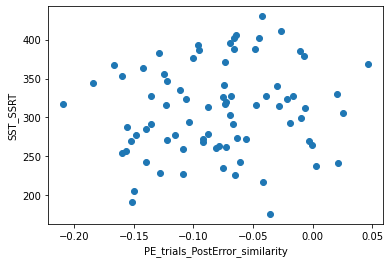

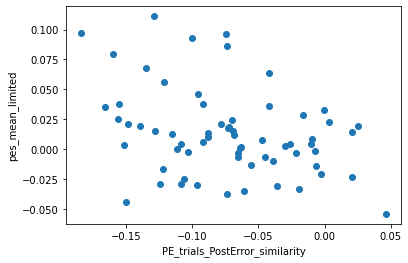

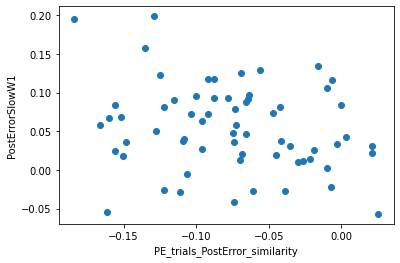

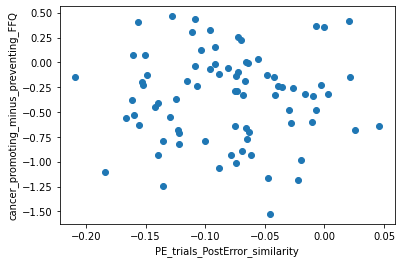

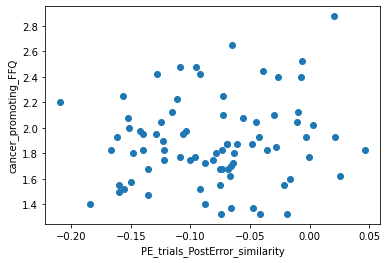

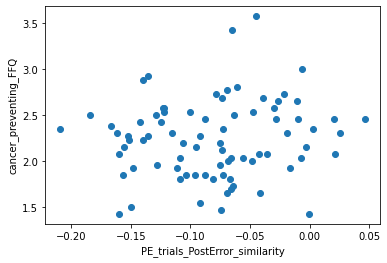

### PC_trials_PostCorrect_similarity

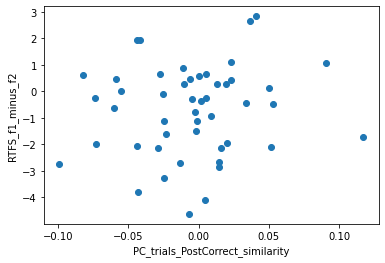

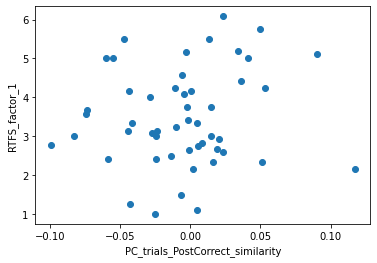

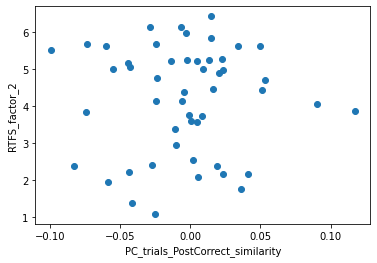

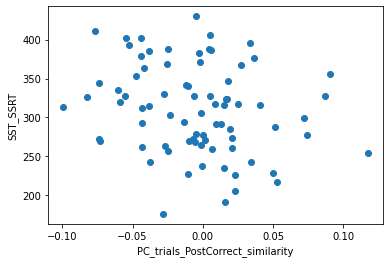

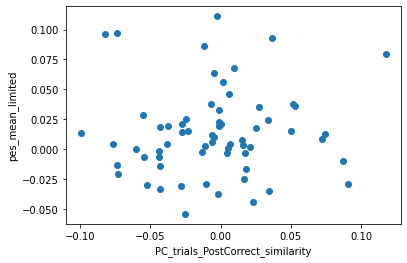

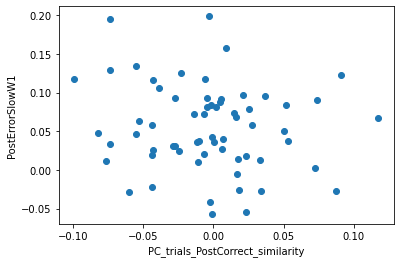

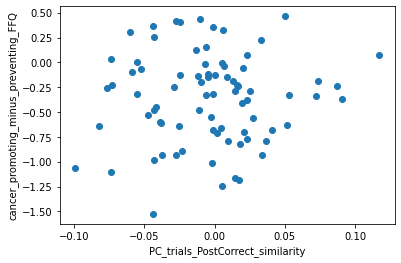

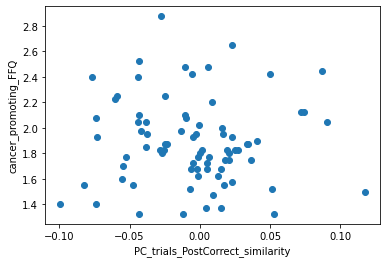

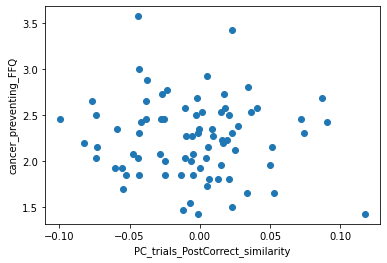

In [28]:
print(results_filepath,flush=True)

print("plotting signatures")

plot_stat_maps(PostError_ns,PostCorrect_ns)

print("loading data")

bd=get_bd(brain_data_filepath,PostError_ns,PostCorrect_ns,relevant_mask)

create_histogram(bd)

ind_div_combined = get_ind_div_for_pes_combined(bd,ml_data_folderpath)

ind_div_combined = remove_selected_outliers_rtfs_study(ind_div_combined,show_plot=False)

for neural_var in ['PE_trials_PostError_similarity','PC_trials_PostCorrect_similarity']:
    display(Markdown("### " + neural_var))
    for correlate in ['RTFS_f1_minus_f2','RTFS_factor_1','RTFS_factor_2','SST_SSRT','pes_mean_limited','PostErrorSlowW1','cancer_promoting_minus_preventing_FFQ',
        'cancer_promoting_FFQ','cancer_preventing_FFQ']:
        visualize_corr(neural_var,correlate,ind_div_combined)

## ACC

In [29]:
dataset_mask_label = 'accmask'
relevant_mask = accmask
results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_84subs_twoclasses_" + dataset_mask_label +".pkl"
brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_posterror_conditions_84subs_correct_cond.pkl'


/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_accmask.pkl
0.6049382716049383


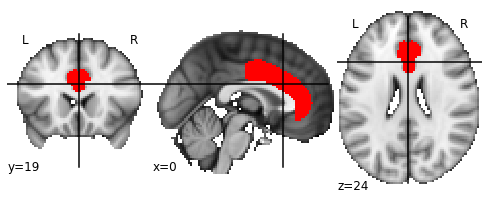

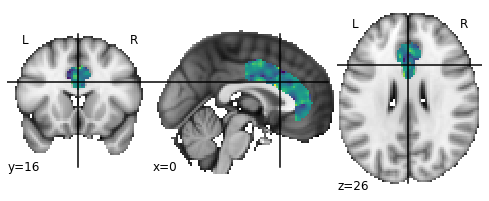

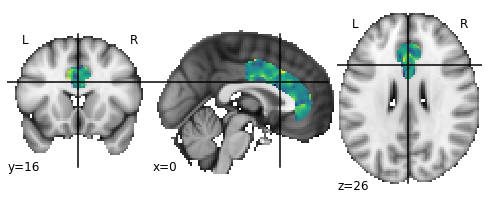

In [30]:
plotting.plot_img(
    relevant_mask,
    threshold='auto',
    cmap='autumn',
    bg_img=background_img)


print(results_filepath)
results=pickle.load(open(results_filepath,'rb'))

print(np.mean(results[0]))

PostCorrect_ns=results[3]['CorrectGoFollowingCorrectStop']
#display(Markdown("### CorrectGoFollowingCorrectStop"))
plotting.plot_img(PostCorrect_ns,threshold='auto',bg_img=background_img)

PostError_ns=results[3]['CorrectGoFollowingFailedStop']
#display(Markdown("### CorrectGoFollowingFailedStop"))
plotting.plot_img(PostError_ns,threshold='auto',bg_img=background_img)

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_accmask.pkl
plotting signatures


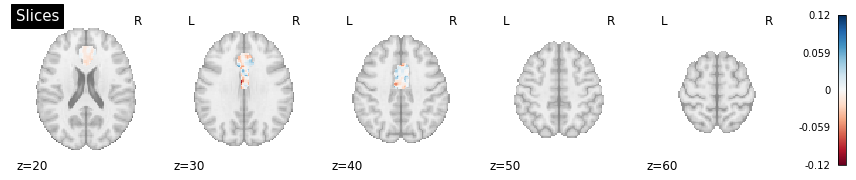

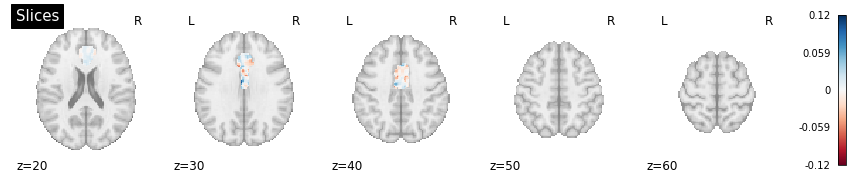

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


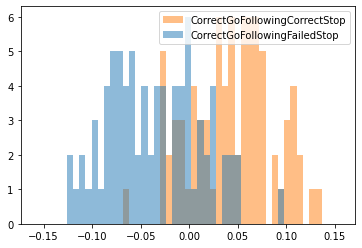

Index(['subid', 'pes_mean_limited'], dtype='object')
Index(['subid', 'PECG_mean', 'PCCG_mean', 'PostErrorSlowW1'], dtype='object')


### PE_trials_PostError_similarity

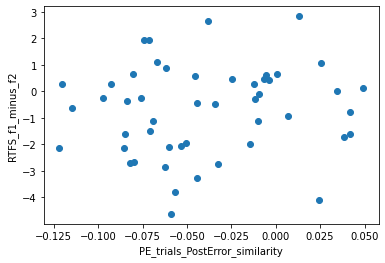

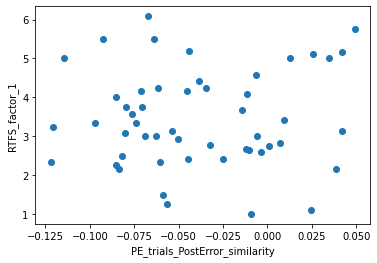

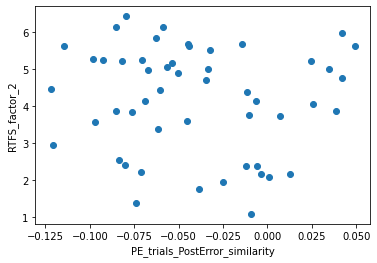

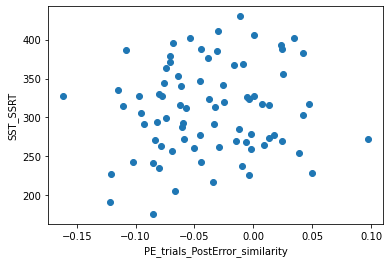

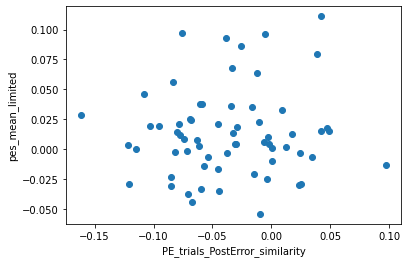

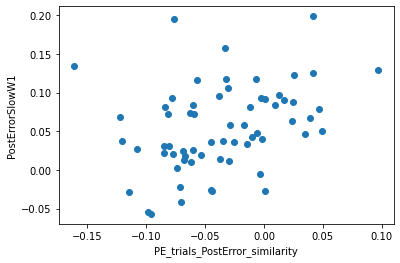

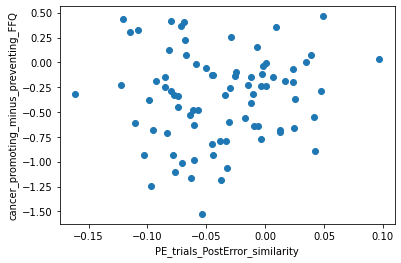

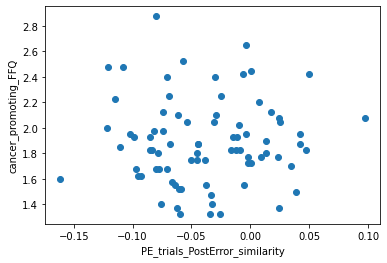

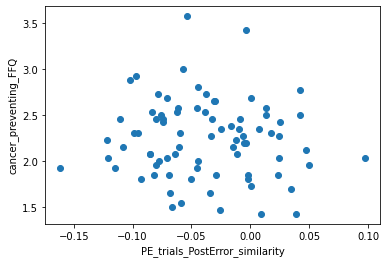

### PC_trials_PostCorrect_similarity

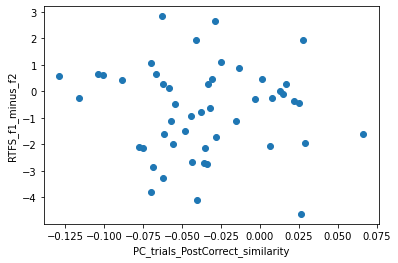

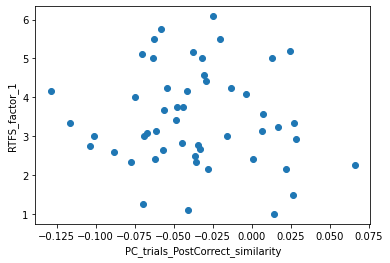

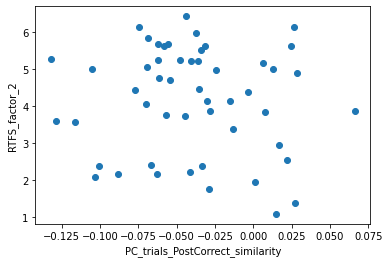

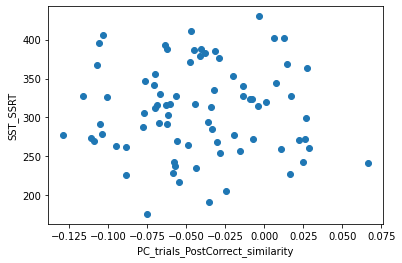

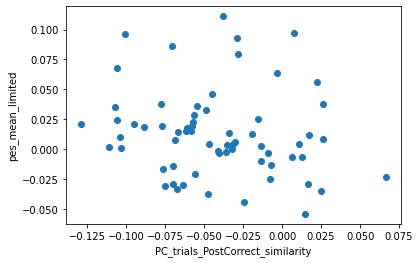

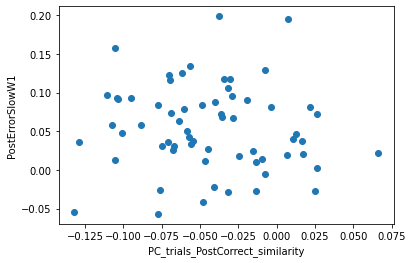

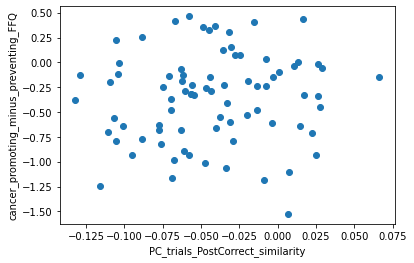

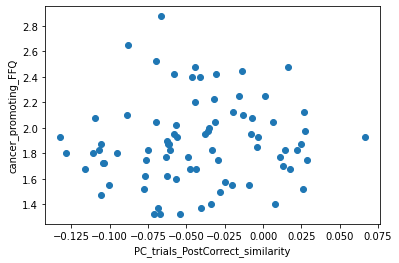

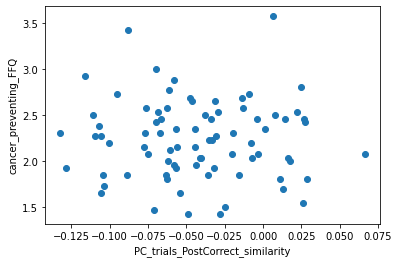

In [31]:
print(results_filepath,flush=True)

print("plotting signatures")

plot_stat_maps(PostError_ns,PostCorrect_ns)

print("loading data")

bd=get_bd(brain_data_filepath,PostError_ns,PostCorrect_ns,relevant_mask)

create_histogram(bd)

ind_div_combined = get_ind_div_for_pes_combined(bd,ml_data_folderpath)

ind_div_combined = remove_selected_outliers_rtfs_study(ind_div_combined,show_plot=False)

for neural_var in ['PE_trials_PostError_similarity','PC_trials_PostCorrect_similarity']:
    display(Markdown("### " + neural_var))
    for correlate in ['RTFS_f1_minus_f2','RTFS_factor_1','RTFS_factor_2','SST_SSRT','pes_mean_limited','PostErrorSlowW1','cancer_promoting_minus_preventing_FFQ',
        'cancer_promoting_FFQ','cancer_preventing_FFQ']:
        visualize_corr(neural_var,correlate,ind_div_combined)

## Whole-brain

In [32]:
dataset_mask_label = 'wholebrain'
relevant_mask = None
results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_84subs_twoclasses_" + dataset_mask_label +".pkl"
brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_posterror_conditions_84subs_correct_cond.pkl'

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_wholebrain.pkl
0.8888888888888888


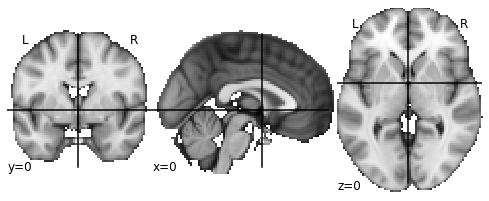

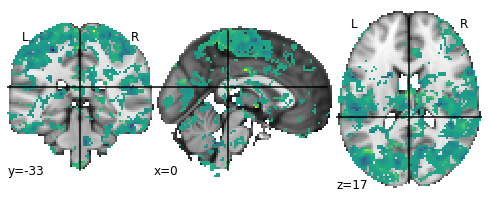

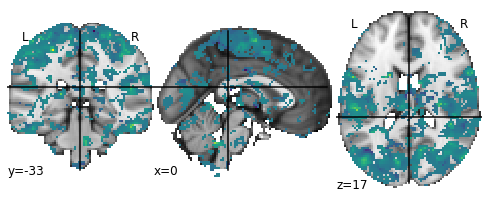

In [33]:
plotting.plot_img(
    relevant_mask,
    threshold='auto',
    cmap='autumn',
    bg_img=background_img)


print(results_filepath)
results=pickle.load(open(results_filepath,'rb'))

print(np.mean(results[0]))

PostCorrect_ns=results[3]['CorrectGoFollowingCorrectStop']
#display(Markdown("### CorrectGoFollowingCorrectStop"))
plotting.plot_img(PostCorrect_ns,threshold='auto',bg_img=background_img)

PostError_ns=results[3]['CorrectGoFollowingFailedStop']
#display(Markdown("### CorrectGoFollowingFailedStop"))
plotting.plot_img(PostError_ns,threshold='auto',bg_img=background_img)

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_wholebrain.pkl
plotting signatures


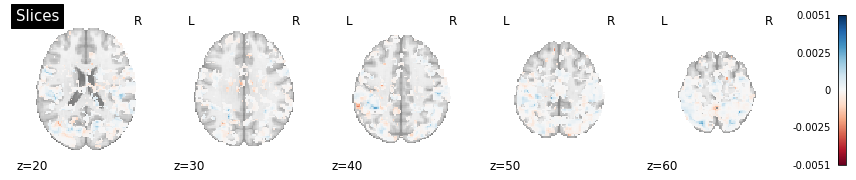

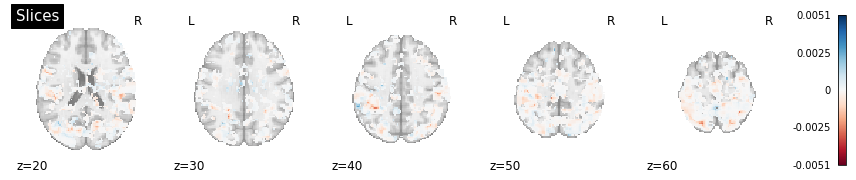

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


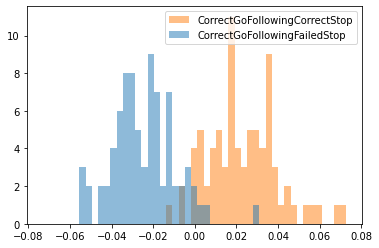

Index(['subid', 'pes_mean_limited'], dtype='object')
Index(['subid', 'PECG_mean', 'PCCG_mean', 'PostErrorSlowW1'], dtype='object')


### PE_trials_PostError_similarity

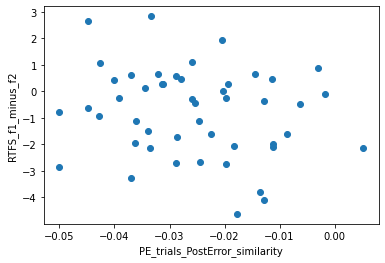

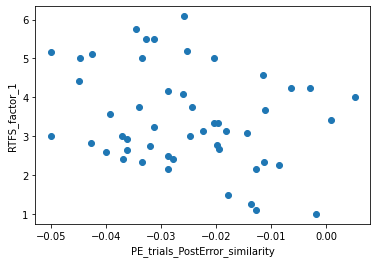

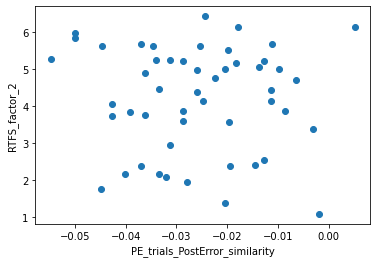

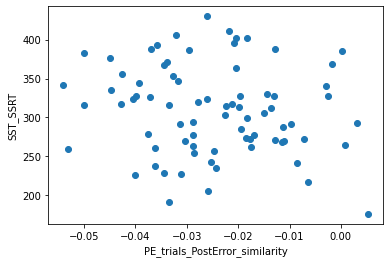

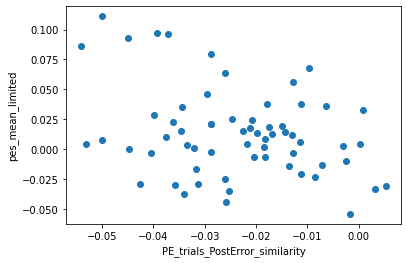

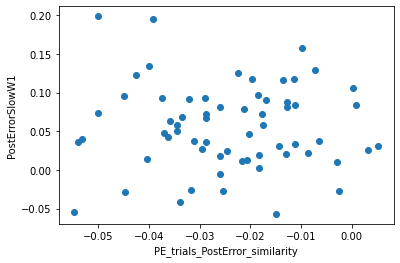

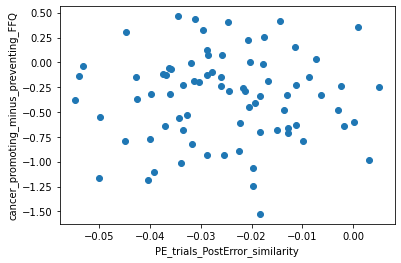

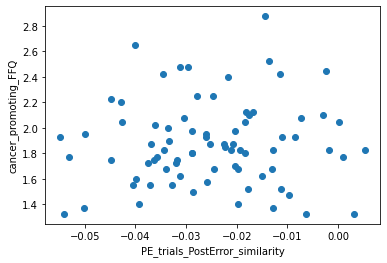

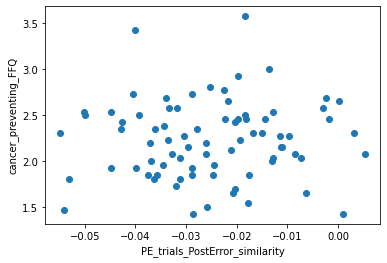

### PC_trials_PostCorrect_similarity

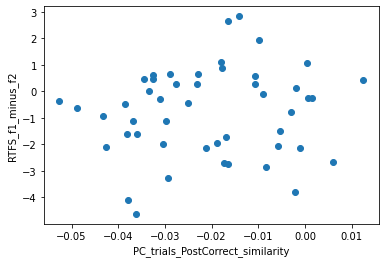

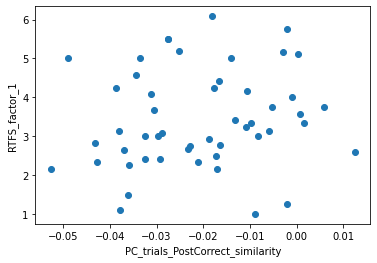

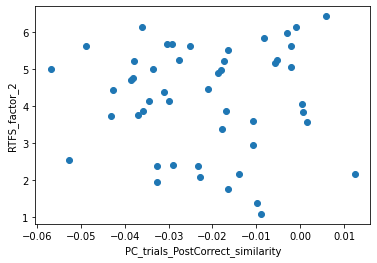

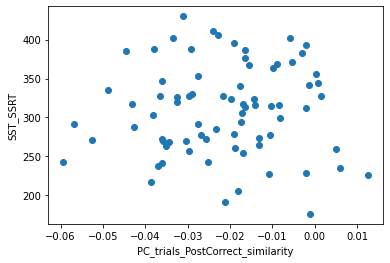

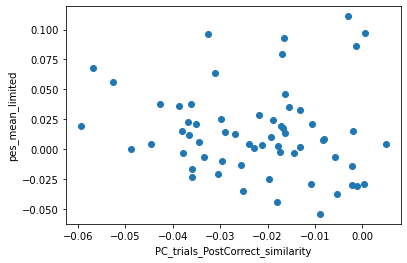

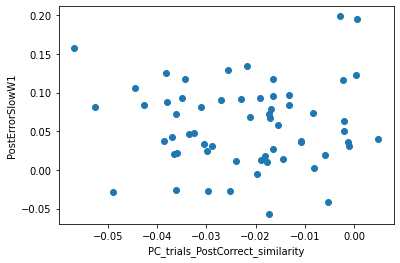

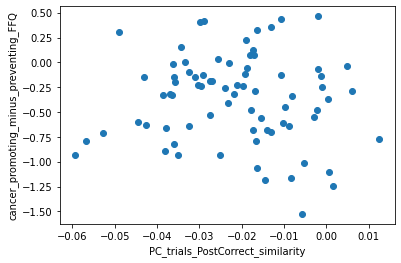

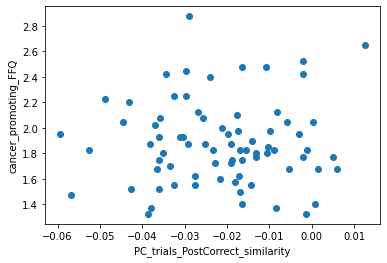

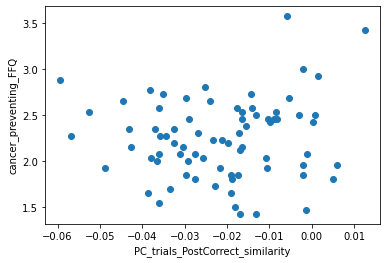

In [34]:
print(results_filepath,flush=True)

print("plotting signatures")

plot_stat_maps(PostError_ns,PostCorrect_ns)

print("loading data")

bd=get_bd(brain_data_filepath,PostError_ns,PostCorrect_ns,relevant_mask)

create_histogram(bd)

ind_div_combined = get_ind_div_for_pes_combined(bd,ml_data_folderpath)

ind_div_combined = remove_selected_outliers_rtfs_study(ind_div_combined,show_plot=False)

for neural_var in ['PE_trials_PostError_similarity','PC_trials_PostCorrect_similarity']:
    display(Markdown("### " + neural_var))
    for correlate in ['RTFS_f1_minus_f2','RTFS_factor_1','RTFS_factor_2','SST_SSRT','pes_mean_limited','PostErrorSlowW1','cancer_promoting_minus_preventing_FFQ',
        'cancer_promoting_FFQ','cancer_preventing_FFQ']:
        visualize_corr(neural_var,correlate,ind_div_combined)
        

# Image contrast

***have we tried getting the CONTRAST of each subjects two images and (a) measuring performance by classification of that contrast; (b) measuring similarity of that?***

This should go exactly as before for the ML learning; the only difference is that we have a different brain data image series to run the contrast with. Let's do the errro analysis...

In [35]:
from analyze_results import plot_stat_maps

In [36]:
dataset_mask_label = 'neurosynth_error_mask'
relevant_mask = neurosynth_error_mask
results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_84subs_twoclasses_" + dataset_mask_label +".pkl"
brain_data_2_cond_filepath = ml_data_folderpath + '/SST/Brain_Data_posterror_conditions_84subs_correct_cond.pkl'
brain_data_condition_contrast_filepath = ml_data_folderpath + '/SST/Brain_Data_posterror_conditions_84subs_condition_contrast.pkl'

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_error_mask.pkl
0.7283950617283951


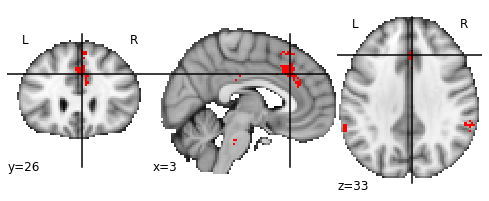

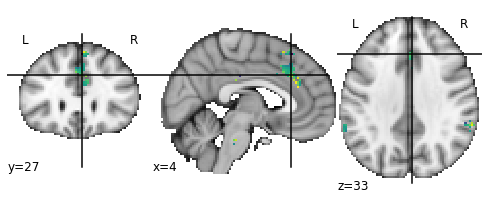

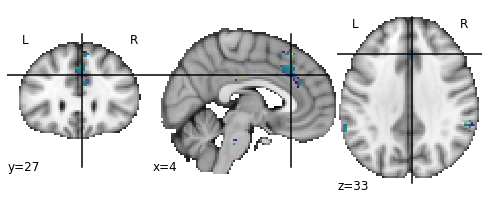

In [37]:
plotting.plot_img(
    relevant_mask,
    threshold='auto',
    cmap='autumn',
    bg_img=background_img)


print(results_filepath)
results=pickle.load(open(results_filepath,'rb'))

print(np.mean(results[0]))

PostCorrect_ns=results[3]['CorrectGoFollowingCorrectStop']
#display(Markdown("### CorrectGoFollowingCorrectStop"))
plotting.plot_img(PostCorrect_ns,threshold='auto',bg_img=background_img)

PostError_ns=results[3]['CorrectGoFollowingFailedStop']
#display(Markdown("### CorrectGoFollowingFailedStop"))
plotting.plot_img(PostError_ns,threshold='auto',bg_img=background_img)

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_error_mask.pkl
plotting signatures


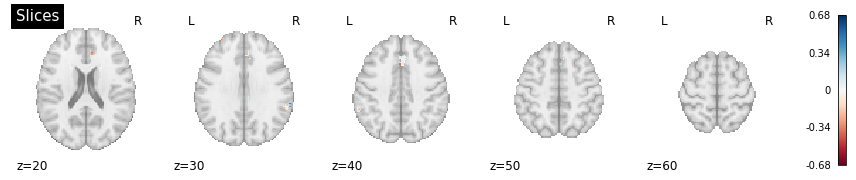

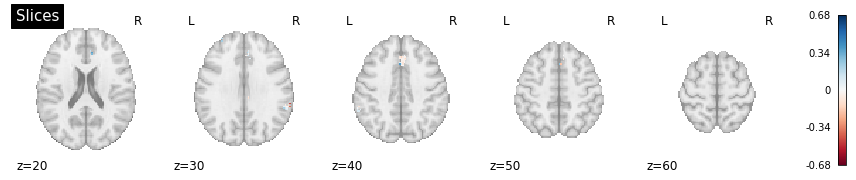

In [38]:
print(results_filepath,flush=True)

print("plotting signatures")

plot_stat_maps(PostError_ns,PostCorrect_ns)



In [39]:
print("loading data")

bd=get_bd(brain_data_filepath,PostError_ns,PostCorrect_ns,relevant_mask)



loading data
applying mask
getting similarity 1
getting similarity 2


In [40]:
def create_condition_contrast(bd, condition_contrast_filepath,condition_0_label,condition_1_label):

    bd.X.reset_index(inplace=True,drop=True)

    bd_contrast = None
    for subject in np.unique(bd.X.subject):
        print(subject,end=", ")
        #get all the indices of images with this subject
        #ensure that we have exactly two images for this subject
        subj_indices = bd.X.index[bd.X.subject==subject]
        if len(subj_indices)!=2:
            raise Exception("should be precisely two images for each subject. there wasn't. look into this.")

        subject_bd = bd[subj_indices]
        condition_0_image = subject_bd[subject_bd.X.condition_label==condition_0_label]
        condition_1_image = subject_bd[subject_bd.X.condition_label==condition_1_label]

        subject_failed_stop_minus_correct_stop = condition_1_image - condition_0_image
        #remove items that aren't relevant for the contrast.
        subject_failed_stop_minus_correct_stop.X.drop(['condition_index','condition_label','raw_beta_description','beta'],axis=1,inplace=True)

        if bd_contrast is None:
            bd_contrast = subject_failed_stop_minus_correct_stop
        else:
            bd_contrast = bd_contrast.append(subject_failed_stop_minus_correct_stop)


    bd_contrast.X.reset_index(inplace=True,drop=True)
    
    with open(condition_contrast_filepath, 'wb') as handle:
        pickle.dump(bd_contrast,handle)
        
    return(bd_contrast)
    
bd_contrast = create_condition_contrast(bd, brain_data_condition_contrast_filepath, "CorrectGoFollowingCorrectStop","CorrectGoFollowingFailedStop")

DEV005, DEV006, DEV010, DEV011, DEV013, DEV014, DEV015, DEV016, DEV017, DEV018, DEV019, DEV020, DEV021, DEV022, DEV023, DEV024, DEV026, DEV027, DEV028, DEV029, DEV030, DEV034, DEV035, DEV036, DEV039, DEV040, DEV041, DEV042, DEV043, DEV046, DEV047, DEV048, DEV049, DEV050, DEV051, DEV052, DEV053, DEV055, DEV056, DEV057, DEV058, DEV059, DEV060, DEV062, DEV064, DEV067, DEV068, DEV069, DEV071, DEV073, DEV074, DEV076, DEV077, DEV079, DEV083, DEV084, DEV085, DEV086, DEV087, DEV089, DEV097, DEV105, DEV107, DEV135, DEV141, DEV145, DEV157, DEV158, DEV159, DEV164, DEV169, DEV171, DEV173, DEV177, DEV186, DEV197, DEV206, DEV215, DEV216, DEV217, DEV218, 

In [41]:
#from analyze_results import get_ind_div_for_pes_combined_contrast

In [42]:
from matplotlib import pyplot

No handles with labels found to put in legend.


creating histograms


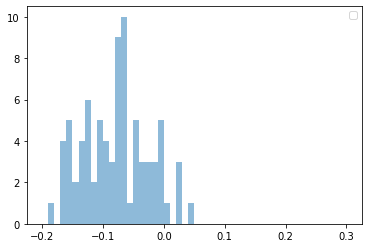

In [43]:
print("creating histograms")
bins=np.linspace(-0.2,0.3,51) #create histogram bins
pyplot.hist(
    bd_contrast.X.PostError_similarity#.to_numpy()
    ,bins=bins
    ,alpha=0.5,histtype='stepfilled')
pyplot.legend(prop={'size': 10})
pyplot.show();


display(HTML(pd.DataFrame(bd_contrast.X.agg({
    'PostError_similarity':"mean",
    'PostCorrect_similarity':"mean"})).to_html()))

In [44]:
def get_ind_div_for_pes_combined_contrast(bd,ml_data_folderpath):

    pes_data = pd.read_csv(ml_data_folderpath + "/post_error_slowing.csv",index_col=0)
    pepc_contrast_data = pd.read_csv(ml_data_folderpath + "/post_error_slowing_simple_approach.csv",index_col=0)

    individual_differences = pd.read_csv(ml_data_folderpath + "/data_by_ppt.csv")
    individual_differences = individual_differences.rename(columns={'SID':'subject'})
    individual_differences['wave']=1
    #individual_differences['wave'] = individual_differences['wave'].astype(object) # for compatibility with the wave column in the dataset

    individual_differences = pd.merge(individual_differences,pes_data,how='outer',left_on='subject',right_on='subid')
    individual_differences = pd.merge(individual_differences,pepc_contrast_data,how='outer',left_on='subject',right_on='subid')

    subject_contrast_neural_performance = bd.X.loc[:,['subject','PostError_similarity','PostCorrect_similarity']]

    subject_contrast_neural_performance.columns = ['contrast_trials_' + col for col in subject_contrast_neural_performance.columns]
    subject_contrast_neural_performance =subject_contrast_neural_performance.rename(columns = {'contrast_trials_subject':'subject'})

    ind_div_combined = subject_contrast_neural_performance.merge(individual_differences,left_on='subject',right_on='subject',how='left')
    #ind_div_combined = remove_selected_outliers(ind_div_combined,show_plot=False)
    
    show_plot=True
    ind_div_combined['pes_mean_limited'] = outlier_detection_median_sd(ind_div_combined['pes_mean_limited'],show_plot=show_plot)
    ind_div_combined['PostErrorSlowW1'] = outlier_detection_median_sd(ind_div_combined['PostErrorSlowW1'],show_plot=show_plot)
    ind_div_combined['IPAQ_MET_kCal'] = outlier_detection_median_sd(ind_div_combined['IPAQ_MET_kCal'],show_plot=show_plot)
#    print(ind_div_combined.columns)
    ind_div_combined['contrast_trials_PostError_similarity'] = outlier_detection_median_sd(ind_div_combined['contrast_trials_PostError_similarity'],show_plot=show_plot)
    ind_div_combined['contrast_trials_PostCorrect_similarity'] = outlier_detection_median_sd(ind_div_combined['contrast_trials_PostCorrect_similarity'],show_plot=show_plot)
    
    return(ind_div_combined)


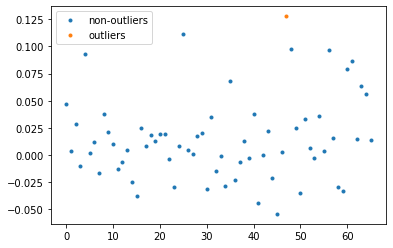

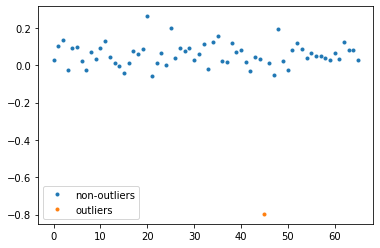

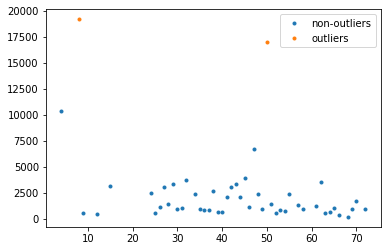

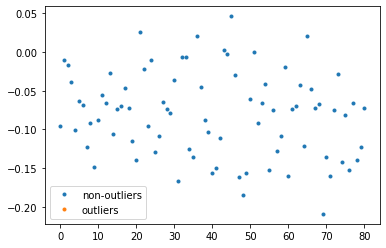

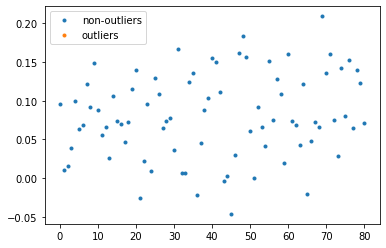

### contrast_trials_PostError_similarity

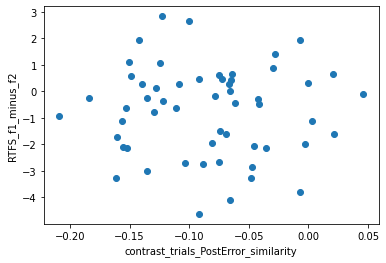

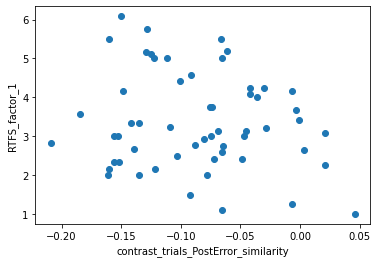

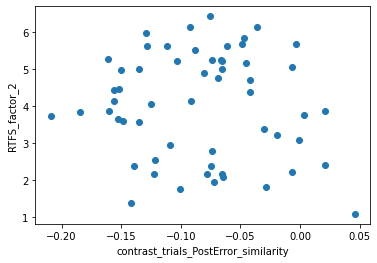

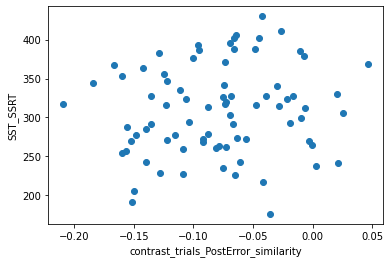

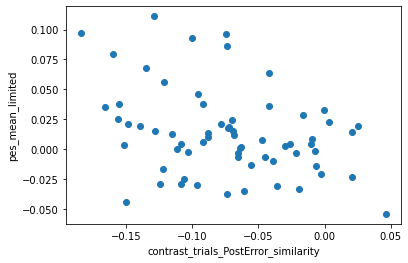

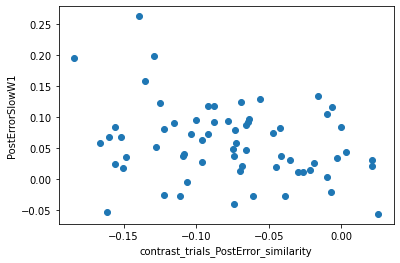

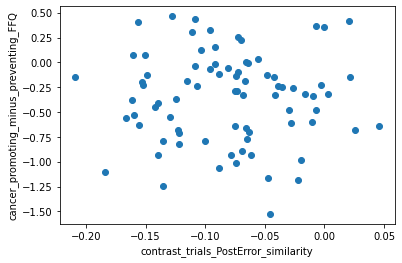

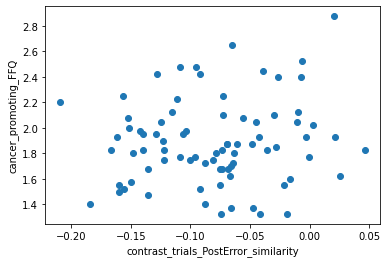

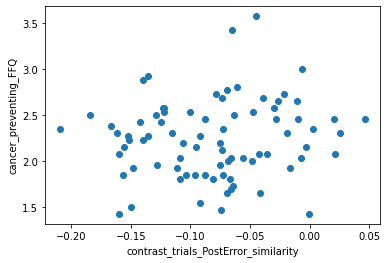

### contrast_trials_PostCorrect_similarity

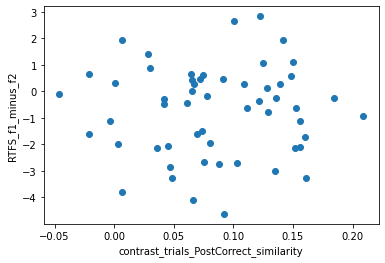

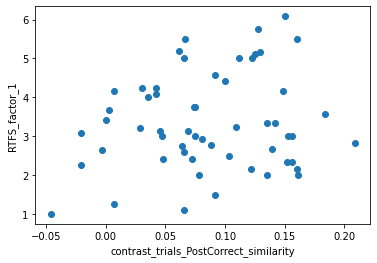

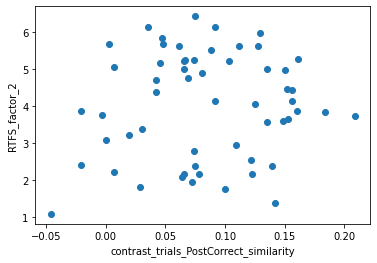

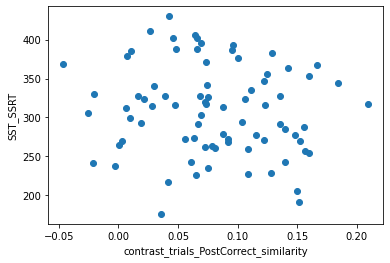

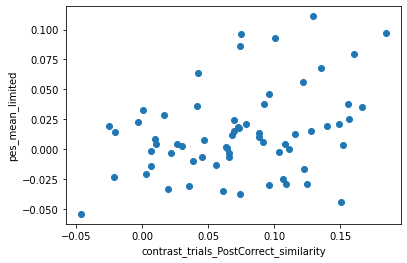

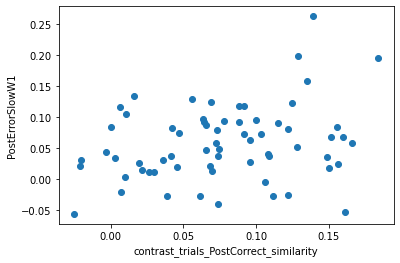

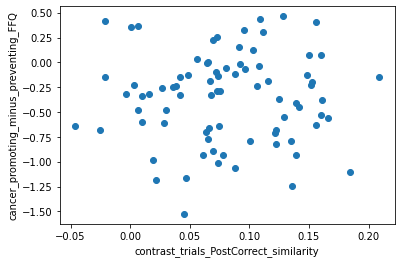

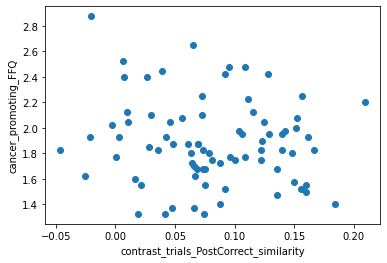

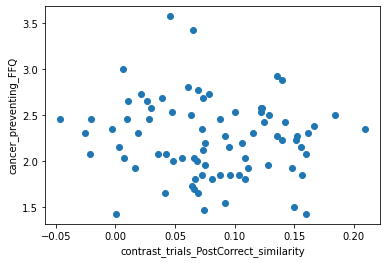

In [45]:
from nilearn import surface
from nilearn import datasets
from nilearn import plotting
from matplotlib import pyplot
from scipy.stats import pearsonr
import pickle
from IPython.core.display import display, HTML, Markdown
from nilearn import plotting
from nilearn.masking import compute_brain_mask
import nltools as nlt
import numpy as np
import pandas as pd

#create_histogram(bd_contrast)

ind_div_combined = get_ind_div_for_pes_combined_contrast(bd_contrast,ml_data_folderpath)

for neural_var in ['contrast_trials_PostError_similarity','contrast_trials_PostCorrect_similarity']:
    display(Markdown("### " + neural_var))
    for correlate in ['RTFS_f1_minus_f2','RTFS_factor_1','RTFS_factor_2','SST_SSRT','pes_mean_limited','PostErrorSlowW1','cancer_promoting_minus_preventing_FFQ',
        'cancer_promoting_FFQ','cancer_preventing_FFQ']:
        visualize_corr(neural_var,correlate,ind_div_combined)

Exactly the same!? need to check. if so, why?

# dot product tests

In [46]:
def run_full_pes_analysis(mask_label,mask_file,similarity_method,include_gender_breakdown=False):
    dataset_mask_label = mask_label
    relevant_mask = mask_file
    results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_84subs_twoclasses_" + dataset_mask_label +".pkl"
    brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_posterror_conditions_84subs_correct_cond.pkl'

    plotting.plot_img(
        relevant_mask,
        threshold='auto',
        cmap='autumn',
        bg_img=background_img)


    print(results_filepath)
    results=pickle.load(open(results_filepath,'rb'))

    print(np.mean(results[0]))

    PostCorrect_ns=results[3]['CorrectGoFollowingCorrectStop']
    #display(Markdown("### CorrectGoFollowingCorrectStop"))
    plotting.plot_img(PostCorrect_ns,threshold='auto',bg_img=background_img)

    PostError_ns=results[3]['CorrectGoFollowingFailedStop']
    #display(Markdown("### CorrectGoFollowingFailedStop"))
    plotting.plot_img(PostError_ns,threshold='auto',bg_img=background_img)

    print(results_filepath,flush=True)

    print("plotting signatures")

    plot_stat_maps(PostError_ns,PostCorrect_ns)

    print("loading data")

    bd=get_bd(brain_data_filepath,PostError_ns,PostCorrect_ns,relevant_mask,similarity_method=similarity_method)

    create_histogram(bd)

    ind_div_combined = get_ind_div_for_pes_combined(bd,ml_data_folderpath)

    ind_div_combined = remove_selected_outliers_rtfs_study(ind_div_combined,show_plot=False)

    for neural_var in ['PE_trials_PostError_similarity','PC_trials_PostCorrect_similarity']:
        display(Markdown("### " + neural_var))
        for correlate in ['RTFS_f1_minus_f2','RTFS_factor_1','RTFS_factor_2','SST_SSRT','pes_mean_limited','PostErrorSlowW1','cancer_promoting_minus_preventing_FFQ',
            'cancer_promoting_FFQ','cancer_preventing_FFQ']:
            visualize_corr(neural_var,correlate,ind_div_combined)
            
    if include_gender_breakdown:
        for bs_f in ['Male','Female']:
            display(Markdown("### " + bs_f))
            for neural_var in ['CS_trials_CS_similarity','CG_trials_CG_similarity']:
                display(Markdown("#### " + neural_var))
                for correlate in ['BFI_extraversion','RMQ_locomotion','ses_aggregate','PLAN_cognitive_strategies','SST_SSRT','BIS_11','BSCS','TESQ_E_suppression', 'TESQ_E_avoidance_of_temptations', 
                                  'TESQ_E_goal_deliberation', 'TESQ_E_controlling_temptations', 'TESQ_E_distraction', 'TESQ_E_goal_and_rule_setting',
                                 'EDM','RS','TRSQ','ROC_Crave_Regulate_Minus_Look','SRHI_unhealthy']:
                    visualize_corr(neural_var,correlate,ind_div_combined.loc[ind_div_combined.birthsex_factor==bs_f,:])




/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_emo_reg_mask.pkl
0.691358024691358
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_emo_reg_mask.pkl
plotting signatures


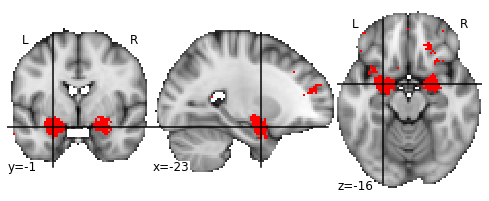

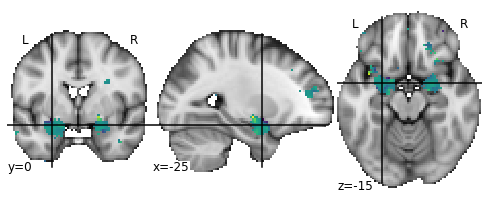

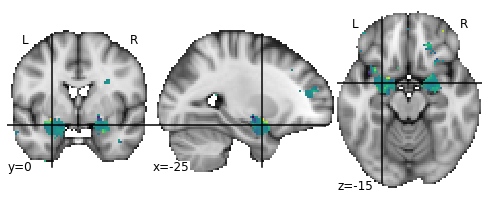

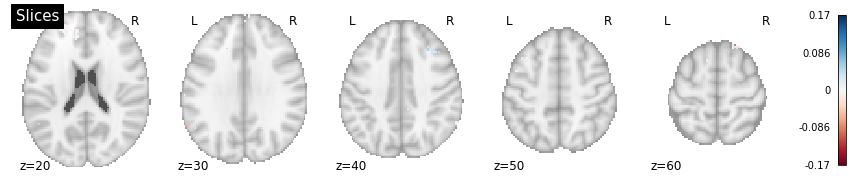

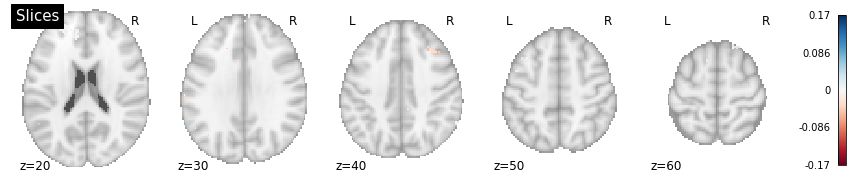

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


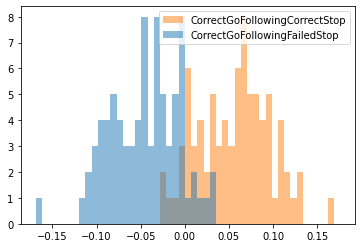

0.009232456815562565 0.07499674494725306 -0.0657642881316905 0.08422920176281562


0.04934769830378225 0.16000871055522017 -0.11066101225143793 0.20935640885900242


1200.7835177866666 4461.633046351562 -3260.849528564896 5662.416564138229


0.05949138925044061 0.13772384065569182 -0.0782324514052512 0.19721522990613244


-0.04635792501891862 0.13162782596348258 -0.1779857509824012 0.08526990094456396


-0.05949138925044061 0.13772384065569182 -0.19721522990613244 0.0782324514052512


0.04635792501891862 0.13162782596348258 -0.08526990094456396 0.1779857509824012


### PE_trials_PostError_similarity

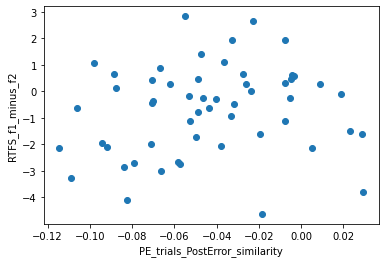

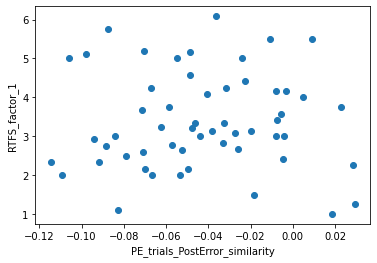

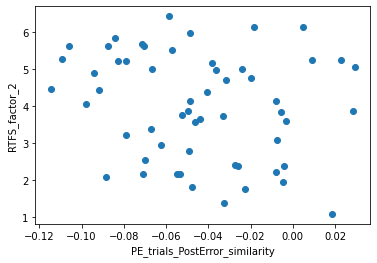

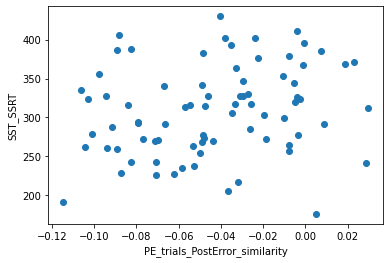

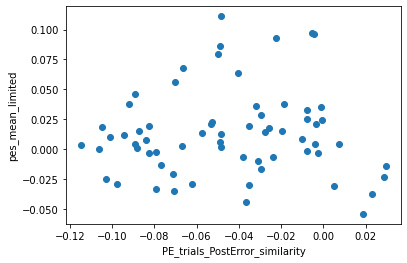

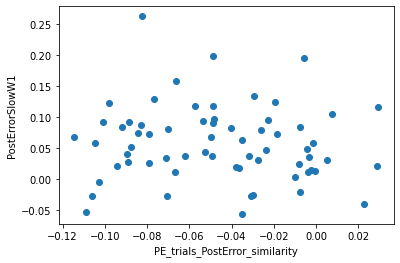

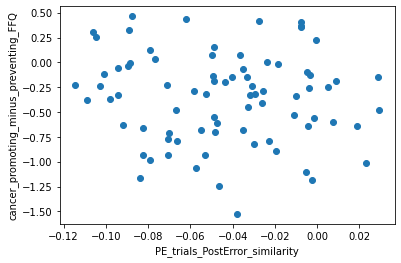

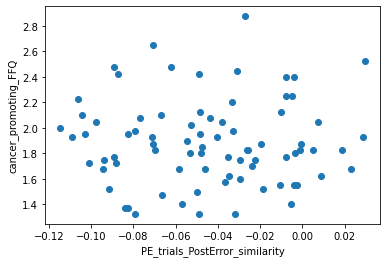

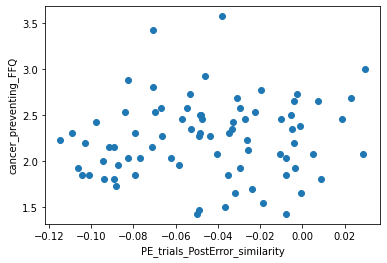

### PC_trials_PostCorrect_similarity

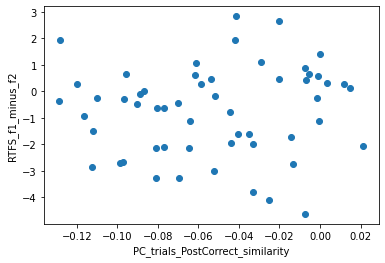

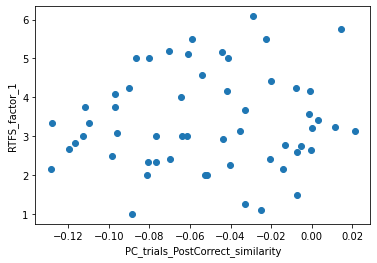

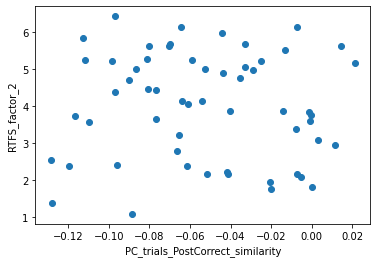

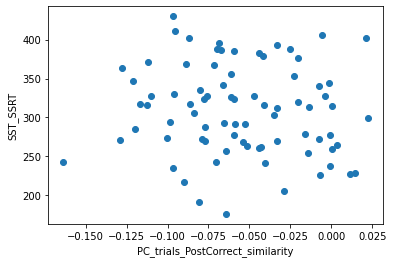

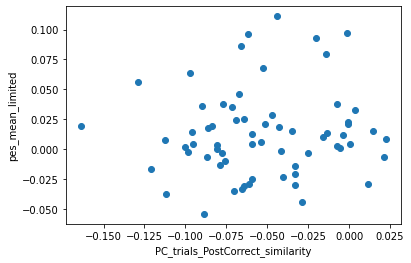

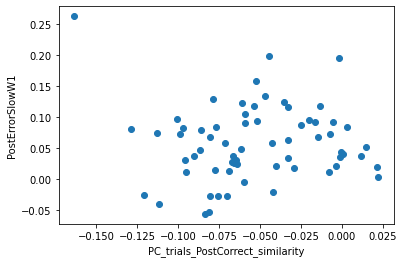

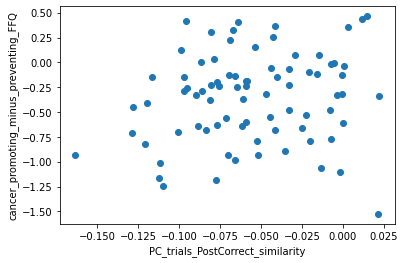

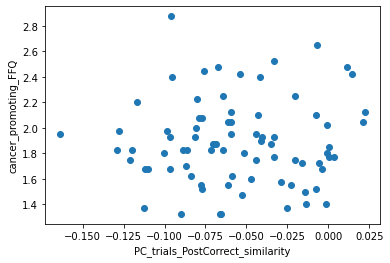

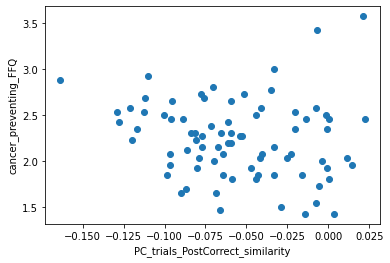

In [46]:
run_full_pes_analysis('neurosynth_emo_reg_mask',neurosynth_emo_reg_mask,'correlation')

In [47]:
#def run_full_pes_analysis(mask_label,mask_file,similarity_method):
mask_label = 'neurosynth_emo_reg_mask'
mask_file=neurosynth_emo_reg_mask
similarity_method = 'dot_product'

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_emo_reg_mask.pkl
0.691358024691358


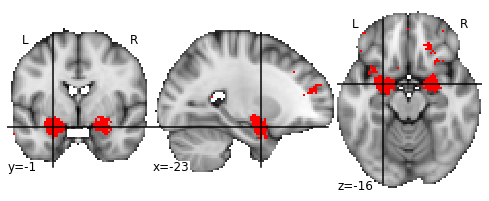

In [48]:


######################################################################



dataset_mask_label = mask_label

relevant_mask = mask_file
results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_84subs_twoclasses_" + dataset_mask_label +".pkl"
brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_posterror_conditions_84subs_correct_cond.pkl'

plotting.plot_img(
    relevant_mask,
    threshold='auto',
    cmap='autumn',
    bg_img=background_img)


print(results_filepath)
results=pickle.load(open(results_filepath,'rb'))

print(np.mean(results[0]))

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_emo_reg_mask.pkl
plotting signatures


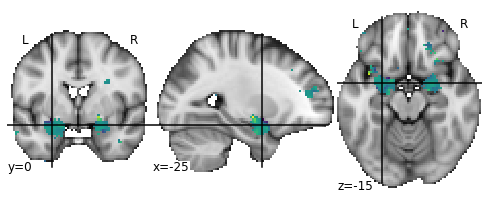

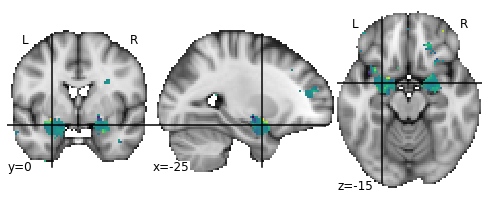

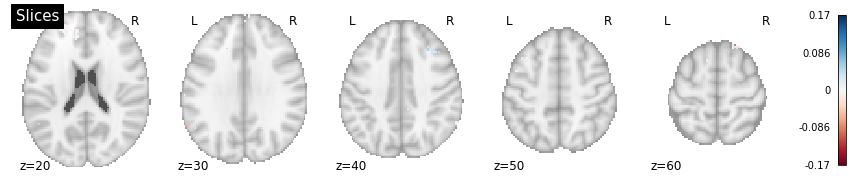

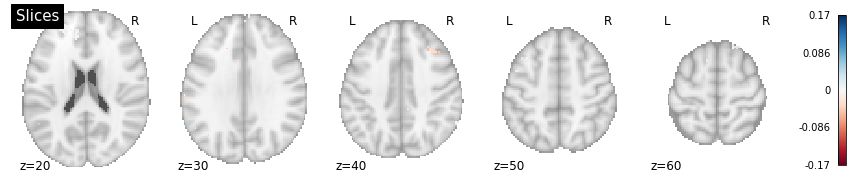

loading data


In [49]:


PostCorrect_ns=results[3]['CorrectGoFollowingCorrectStop']
#display(Markdown("### CorrectGoFollowingCorrectStop"))
plotting.plot_img(PostCorrect_ns,threshold='auto',bg_img=background_img)

PostError_ns=results[3]['CorrectGoFollowingFailedStop']
#display(Markdown("### CorrectGoFollowingFailedStop"))
plotting.plot_img(PostError_ns,threshold='auto',bg_img=background_img)

print(results_filepath,flush=True)

print("plotting signatures")

plot_stat_maps(PostError_ns,PostCorrect_ns)

print("loading data")



/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_emo_reg_mask.pkl
0.691358024691358
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_emo_reg_mask.pkl
plotting signatures


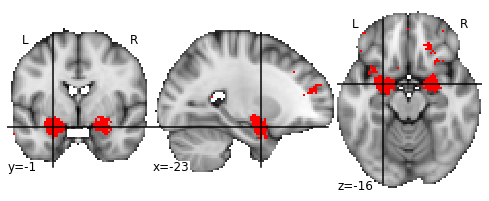

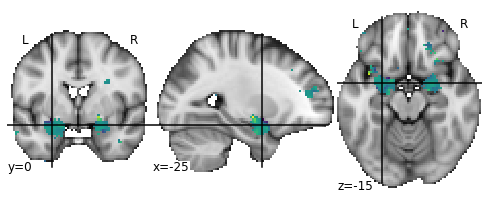

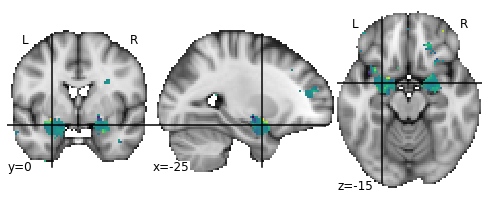

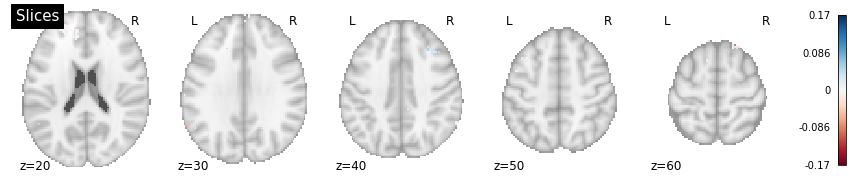

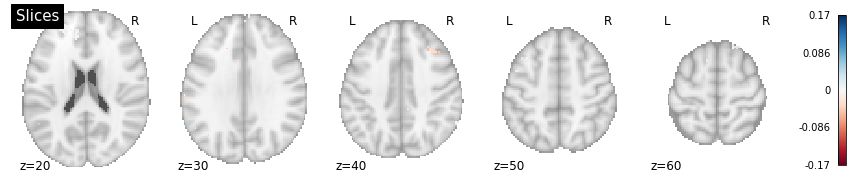

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


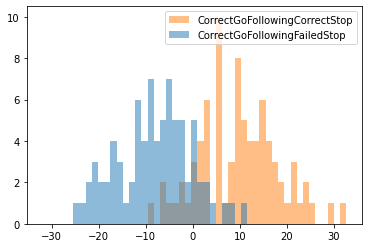

0.009232456815562565 0.07499674494725306 -0.0657642881316905 0.08422920176281562


0.04934769830378225 0.16000871055522017 -0.11066101225143793 0.20935640885900242


1200.7835177866666 4461.633046351562 -3260.849528564896 5662.416564138229


9.857011582467777 25.526426909875376 -15.669415327407599 35.38343849234315


-8.073765236074093 23.719836549815444 -31.793601785889535 15.64607131374135


-9.857011582467777 25.526426909875376 -35.38343849234315 15.669415327407599


8.073765236074093 23.719836549815444 -15.64607131374135 31.793601785889535


### PE_trials_PostError_similarity

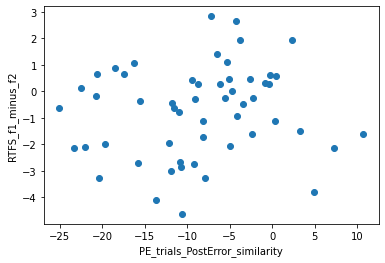

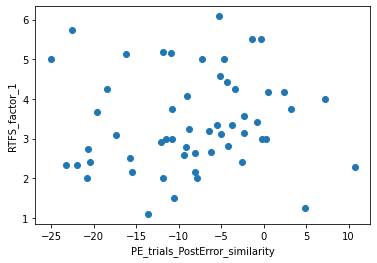

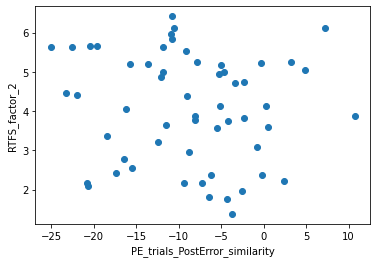

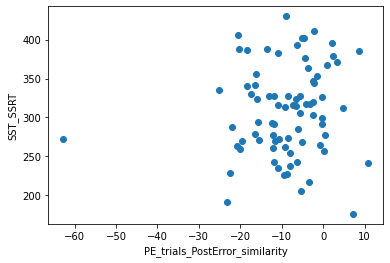

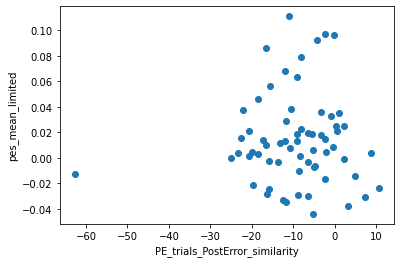

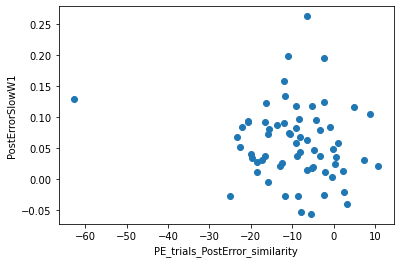

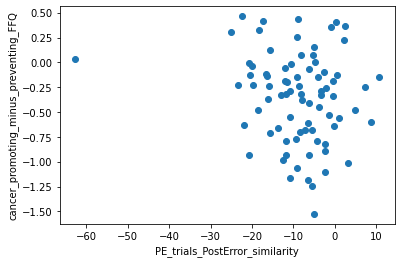

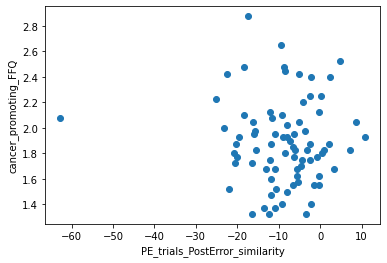

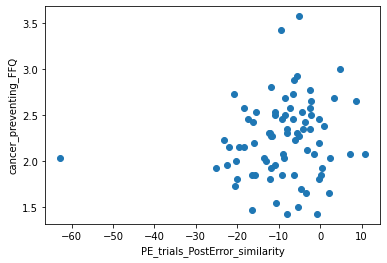

### PC_trials_PostCorrect_similarity

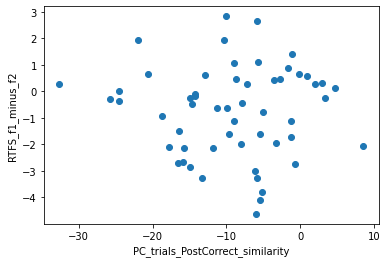

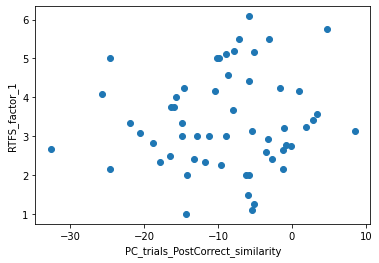

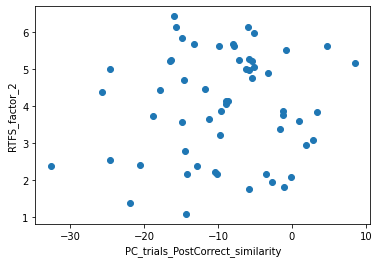

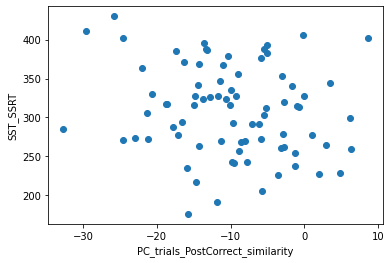

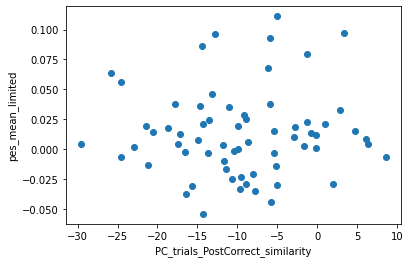

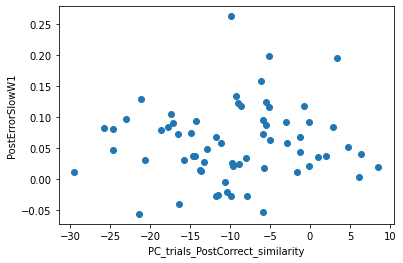

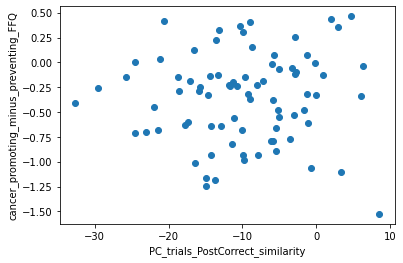

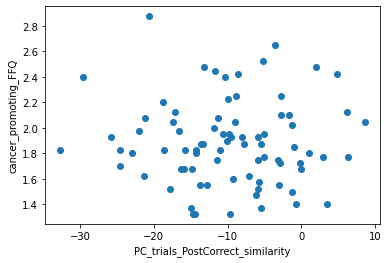

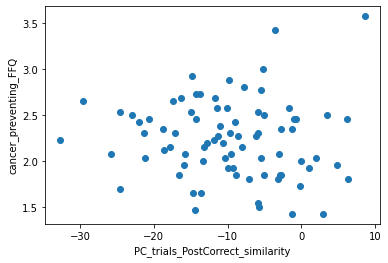

In [50]:
run_full_pes_analysis('neurosynth_emo_reg_mask',neurosynth_emo_reg_mask,'dot_product')

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_error_mask.pkl
0.7283950617283951
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_error_mask.pkl
plotting signatures


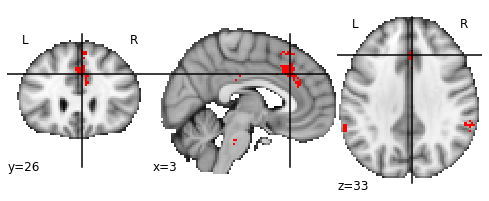

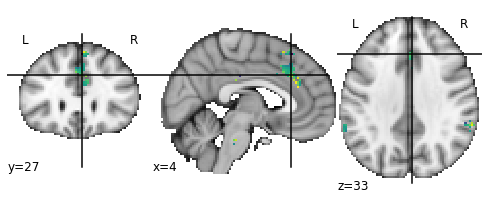

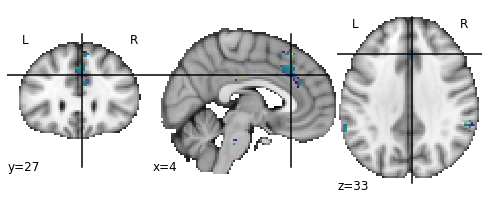

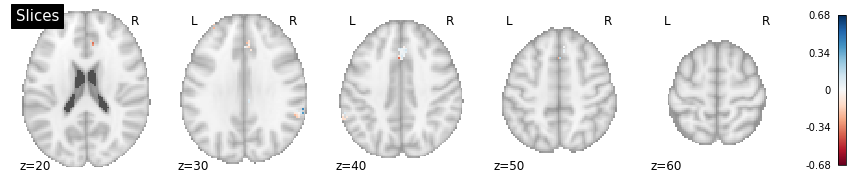

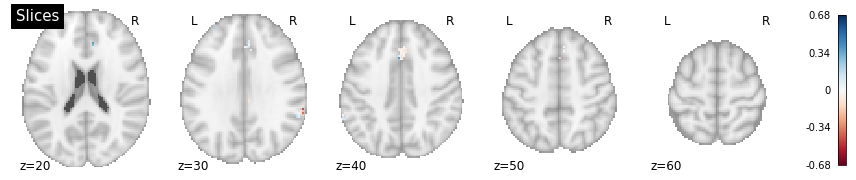

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


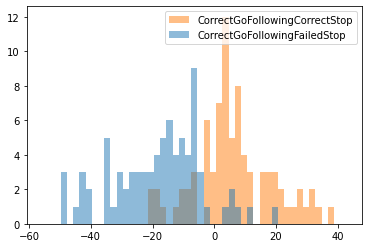

0.009232456815562565 0.07499674494725306 -0.0657642881316905 0.08422920176281562


0.04934769830378225 0.16000871055522017 -0.11066101225143793 0.20935640885900242


1200.7835177866666 4461.633046351562 -3260.849528564896 5662.416564138229


4.555536603702939 26.822060792207758 -22.266524188504818 31.377597395910698


-16.483999405975734 44.42153691762886 -60.90553632360459 27.93753751165313


-4.555536603702939 26.822060792207758 -31.377597395910698 22.266524188504818


16.483999405975734 44.42153691762886 -27.93753751165313 60.90553632360459


### PE_trials_PostError_similarity

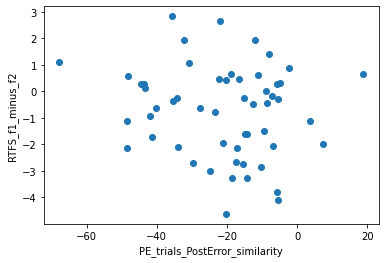

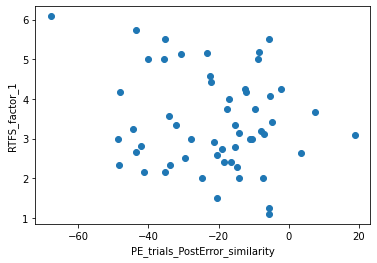

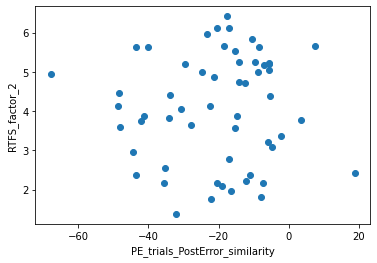

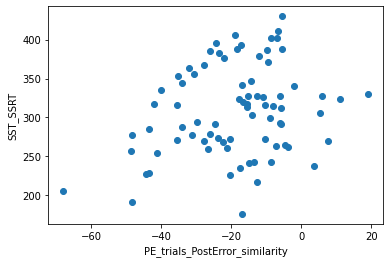

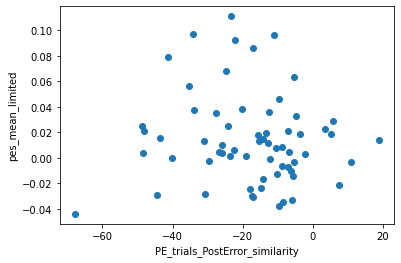

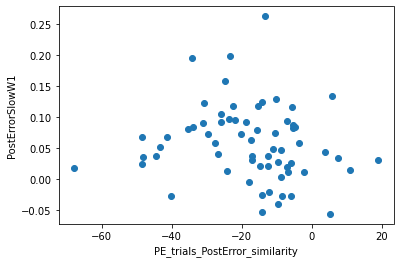

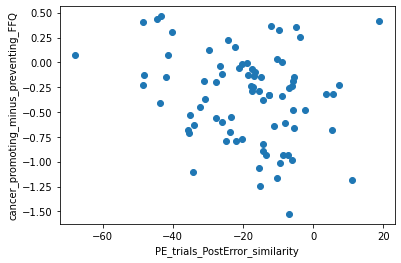

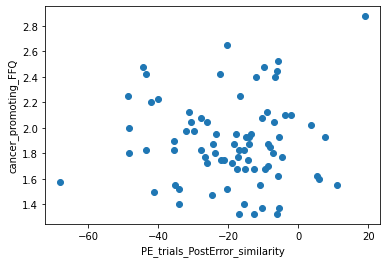

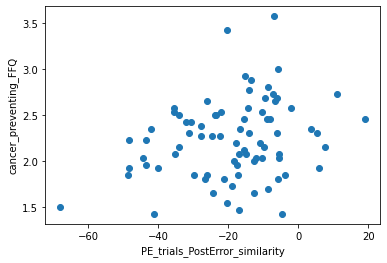

### PC_trials_PostCorrect_similarity

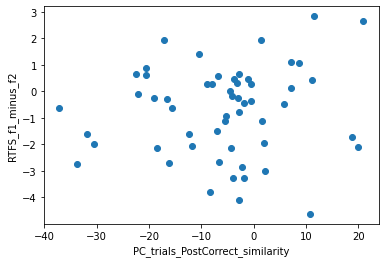

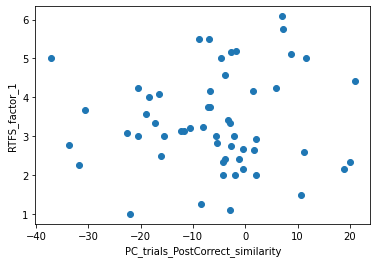

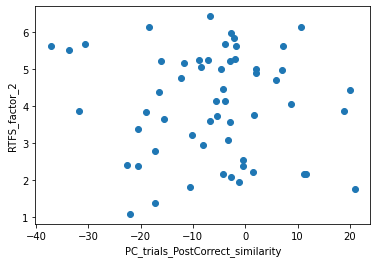

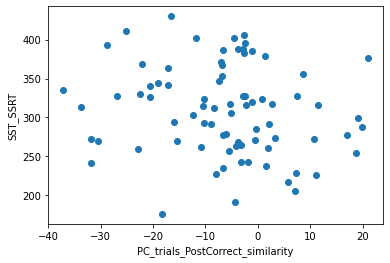

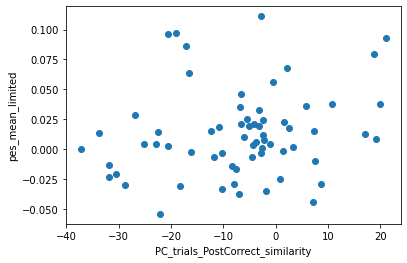

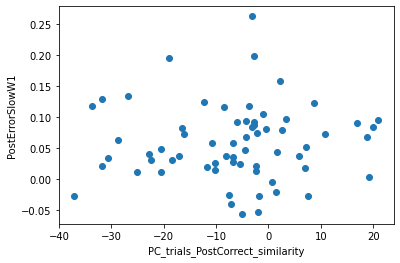

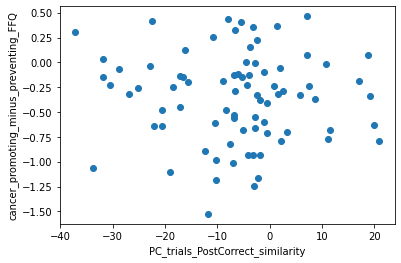

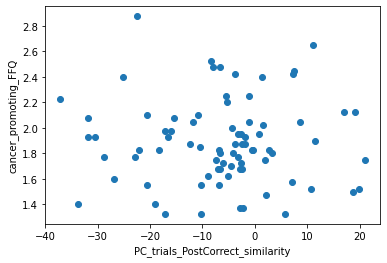

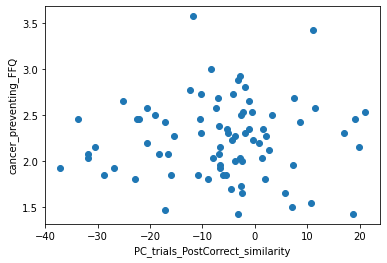

In [51]:
run_full_pes_analysis('neurosynth_error_mask',neurosynth_error_mask,'dot_product')

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_accmask.pkl
0.6049382716049383
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_accmask.pkl
plotting signatures


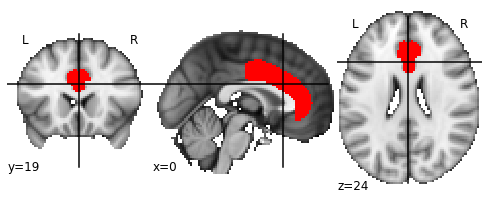

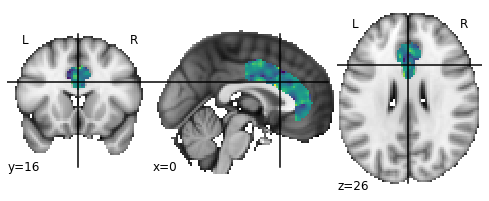

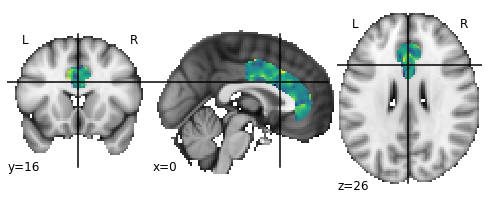

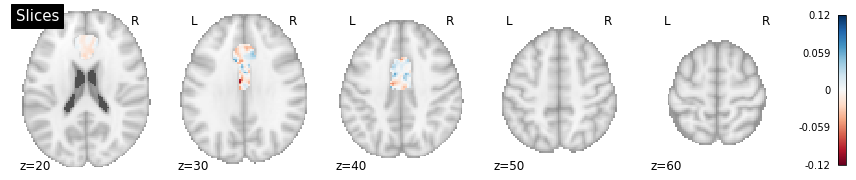

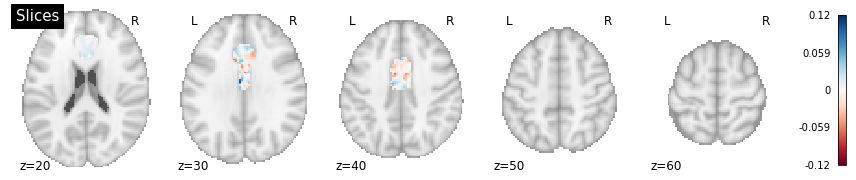

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


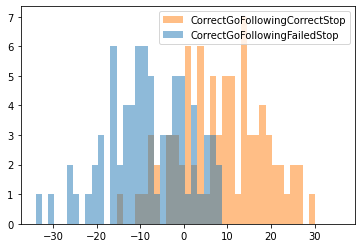

0.009232456815562565 0.07499674494725306 -0.0657642881316905 0.08422920176281562


0.04934769830378225 0.16000871055522017 -0.11066101225143793 0.20935640885900242


1200.7835177866666 4461.633046351562 -3260.849528564896 5662.416564138229


9.02707504222727 33.1295062698083 -24.102431227581032 42.15658131203557


-8.777547035726595 32.765618950952806 -41.5431659866794 23.98807191522621


-9.02707504222727 33.1295062698083 -42.15658131203557 24.102431227581032


8.777547035726595 32.765618950952806 -23.98807191522621 41.5431659866794


### PE_trials_PostError_similarity

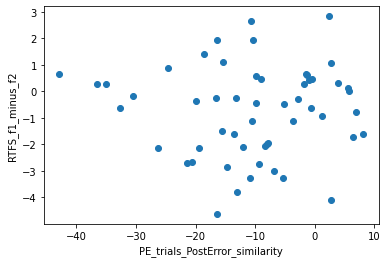

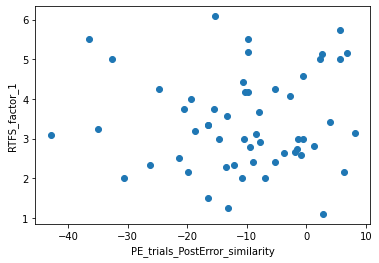

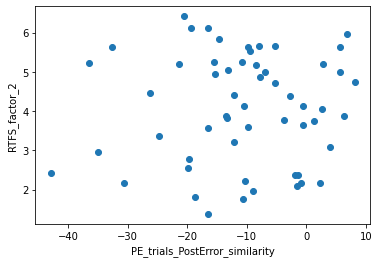

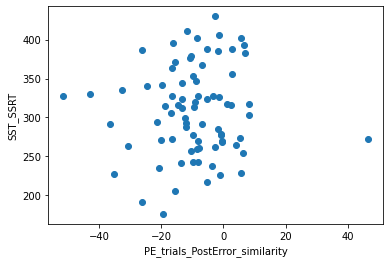

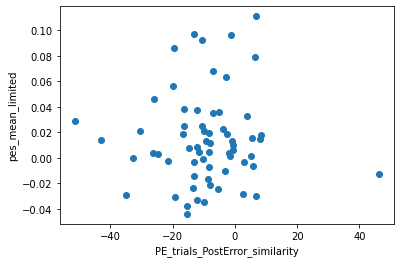

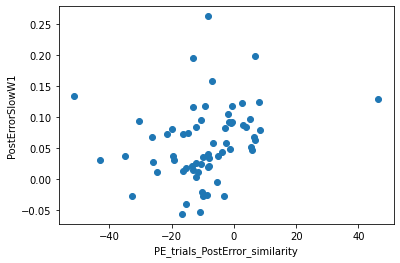

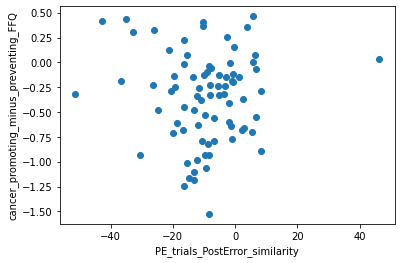

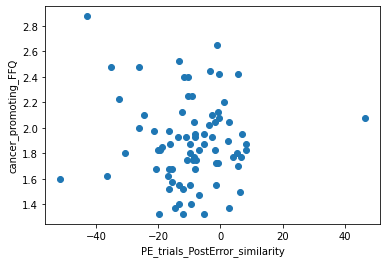

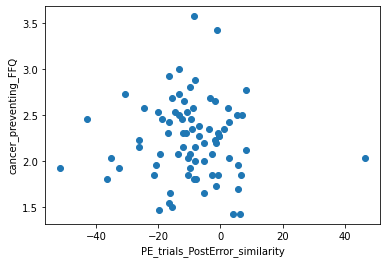

### PC_trials_PostCorrect_similarity

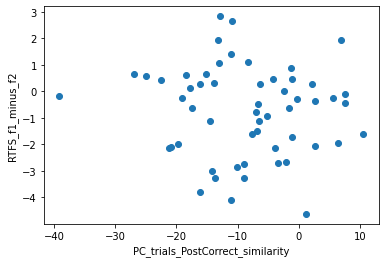

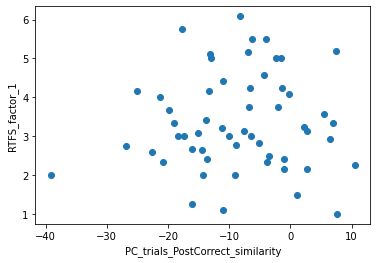

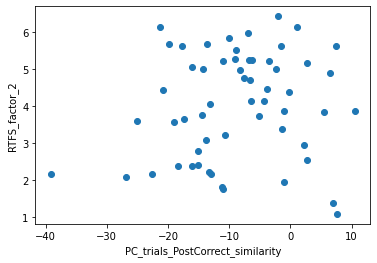

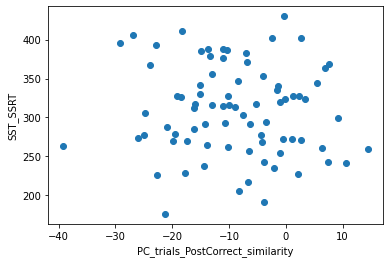

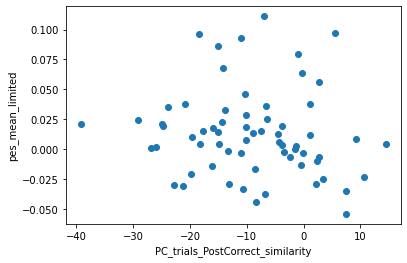

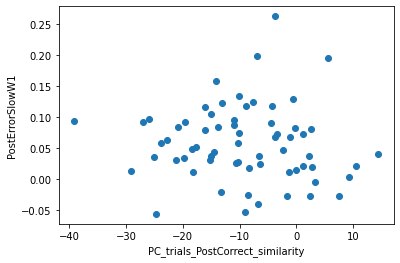

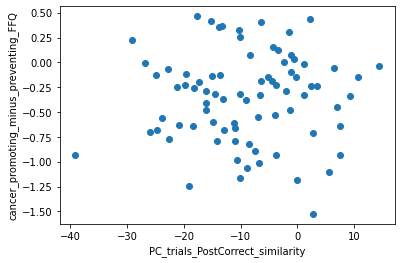

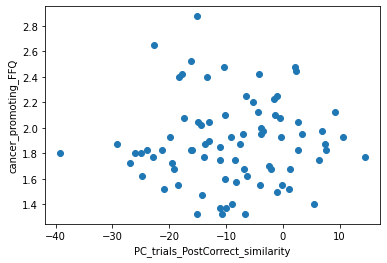

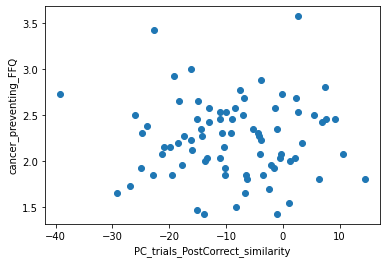

In [52]:
#ACC
run_full_pes_analysis('accmask',accmask,'dot_product')

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_wholebrain.pkl
0.8888888888888888
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_wholebrain.pkl
plotting signatures


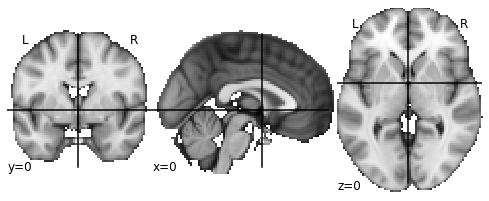

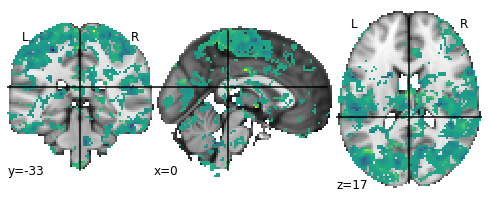

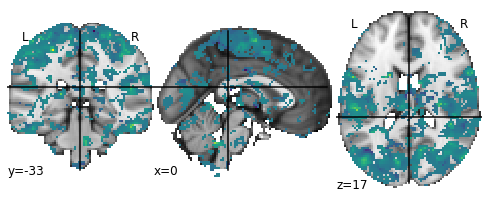

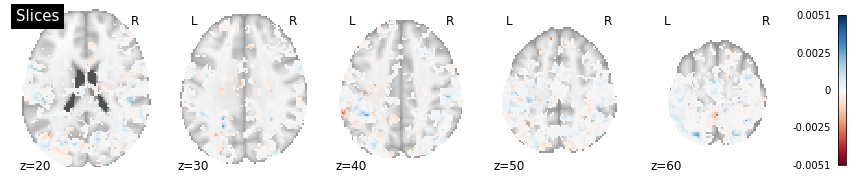

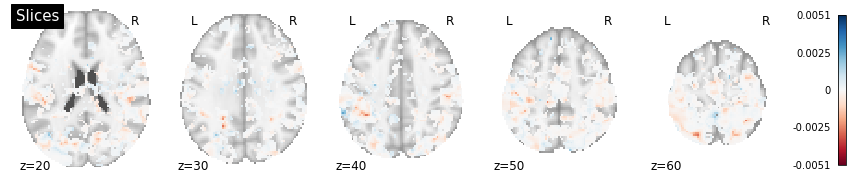

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


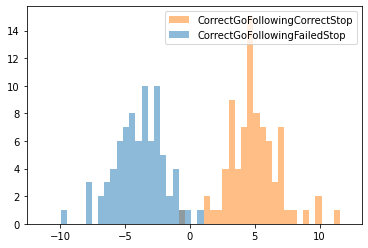

0.009232456815562565 0.07499674494725306 -0.0657642881316905 0.08422920176281562


0.04934769830378225 0.16000871055522017 -0.11066101225143793 0.20935640885900242


1200.7835177866666 4461.633046351562 -3260.849528564896 5662.416564138229


4.872617978045989 5.159237045882512 -0.286619067836523 10.0318550239285


-3.8214337347524667 5.6639886574443405 -9.485422392196806 1.8425549226918738


-4.872617978045989 5.159237045882512 -10.0318550239285 0.286619067836523


3.8214337347524667 5.6639886574443405 -1.8425549226918738 9.485422392196806


### PE_trials_PostError_similarity

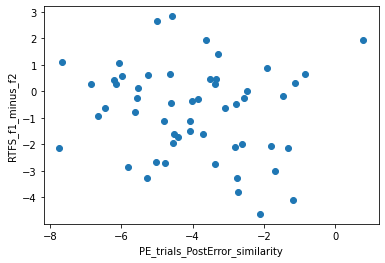

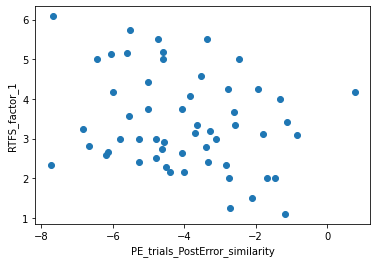

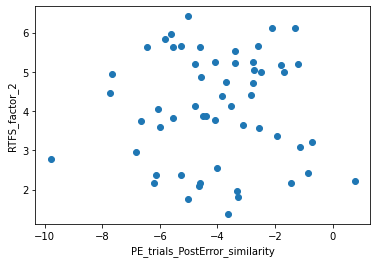

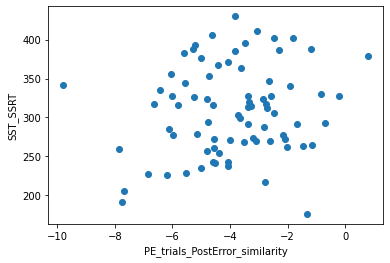

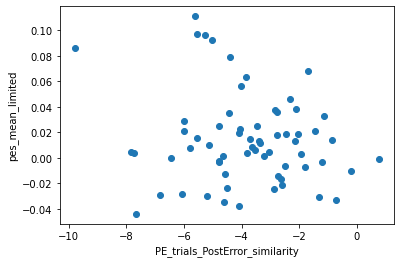

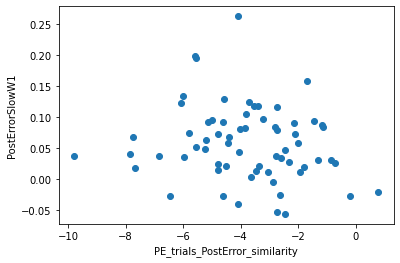

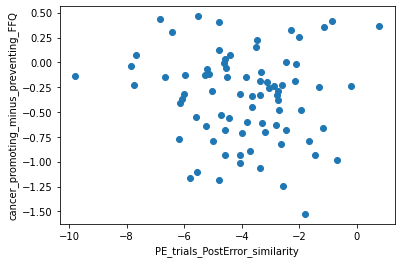

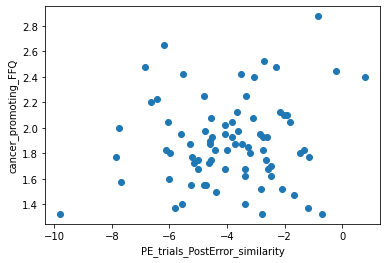

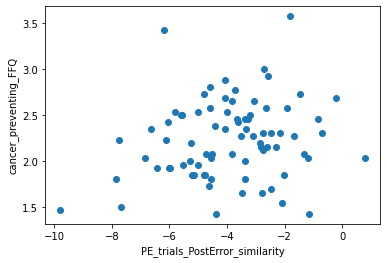

### PC_trials_PostCorrect_similarity

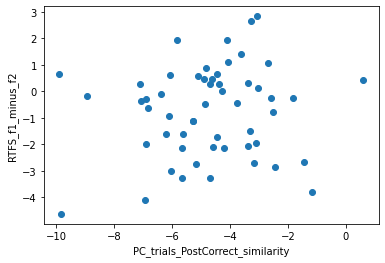

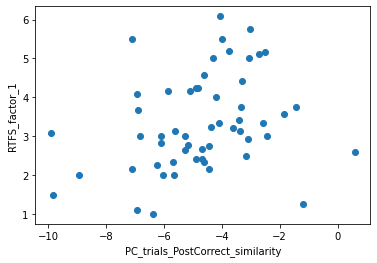

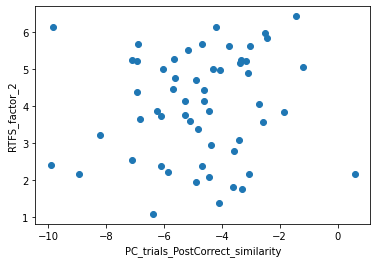

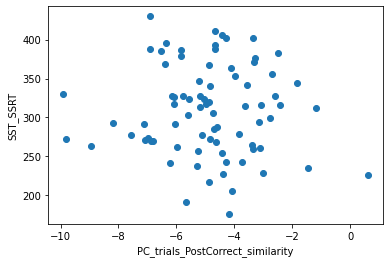

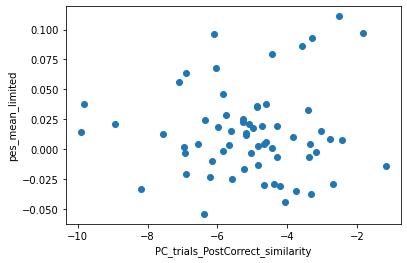

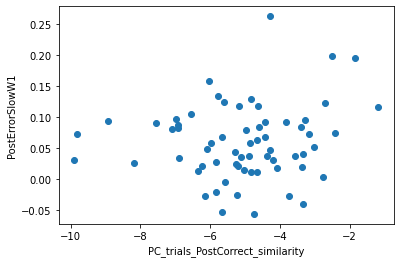

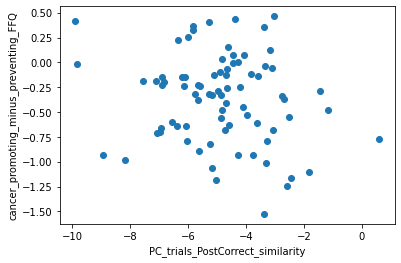

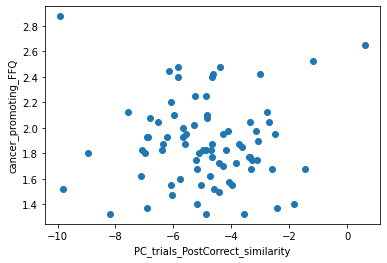

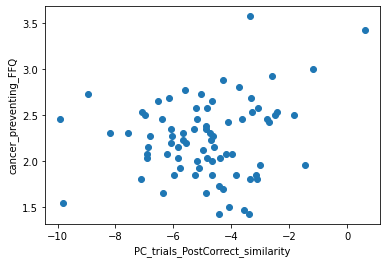

In [53]:
#wholebrain
run_full_pes_analysis('wholebrain',None,'dot_product')

# Gender balance

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_error_mask.pkl
0.7283950617283951
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_neurosynth_error_mask.pkl
plotting signatures


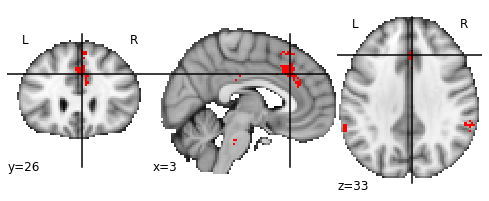

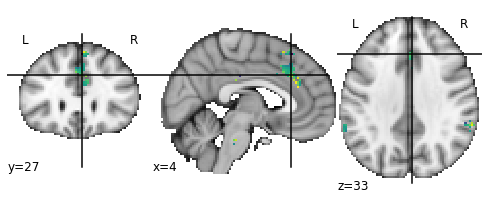

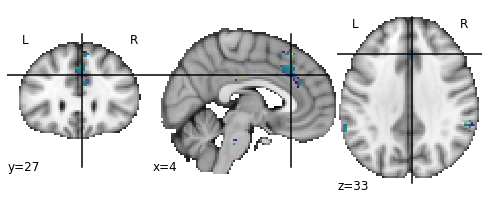

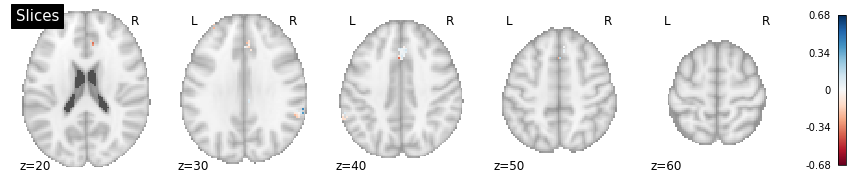

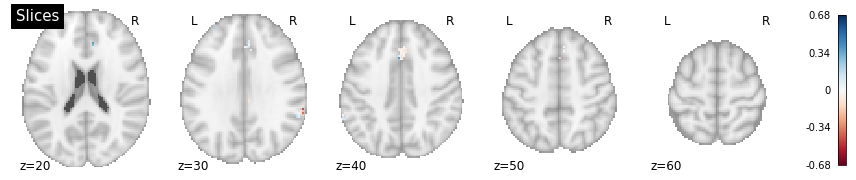

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


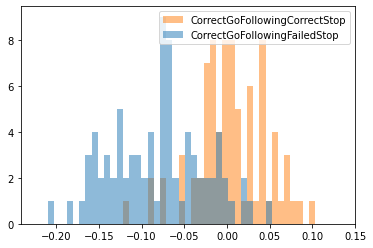

0.009232456815562565 0.07499674494725306 -0.0657642881316905 0.08422920176281562


0.04934769830378225 0.16000871055522017 -0.11066101225143793 0.20935640885900242


1200.7835177866666 4461.633046351562 -3260.849528564896 5662.416564138229


0.0027545238643425347 0.1272198113945678 -0.12446528753022527 0.12997433525891033


-0.0740371951470059 0.18151830717117098 -0.25555550231817686 0.10748111202416509


-0.0027545238643425347 0.1272198113945678 -0.12997433525891033 0.12446528753022527


0.0740371951470059 0.18151830717117098 -0.10748111202416509 0.25555550231817686


In [54]:
mask_label='neurosynth_error_mask'
mask_file=neurosynth_error_mask
similarity_method='correlation'
include_gender_breakdown=True
#def run_full_pes_analysis(mask_label,mask_file,similarity_method,include_gender_breakdown=False):
dataset_mask_label = mask_label
relevant_mask = mask_file
results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_84subs_twoclasses_" + dataset_mask_label +".pkl"
brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_posterror_conditions_84subs_correct_cond.pkl'

plotting.plot_img(
    relevant_mask,
    threshold='auto',
    cmap='autumn',
    bg_img=background_img)


print(results_filepath)
results=pickle.load(open(results_filepath,'rb'))

print(np.mean(results[0]))

PostCorrect_ns=results[3]['CorrectGoFollowingCorrectStop']
#display(Markdown("### CorrectGoFollowingCorrectStop"))
plotting.plot_img(PostCorrect_ns,threshold='auto',bg_img=background_img)

PostError_ns=results[3]['CorrectGoFollowingFailedStop']
#display(Markdown("### CorrectGoFollowingFailedStop"))
plotting.plot_img(PostError_ns,threshold='auto',bg_img=background_img)

print(results_filepath,flush=True)

print("plotting signatures")

plot_stat_maps(PostError_ns,PostCorrect_ns)

print("loading data")

bd=get_bd(brain_data_filepath,PostError_ns,PostCorrect_ns,relevant_mask,similarity_method=similarity_method)

create_histogram(bd)

ind_div_combined = get_ind_div_for_pes_combined(bd,ml_data_folderpath)

ind_div_combined = remove_selected_outliers(ind_div_combined,show_plot=False)


### PE_trials_PostError_similarity

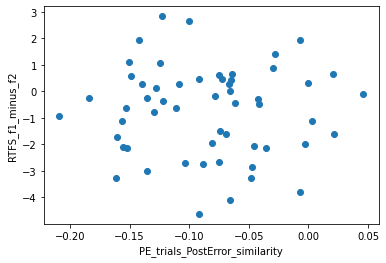

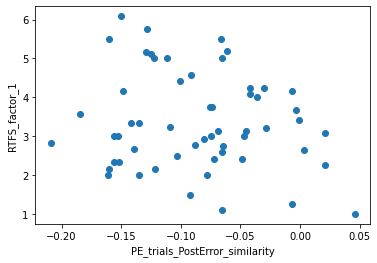

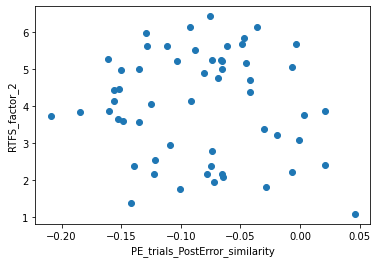

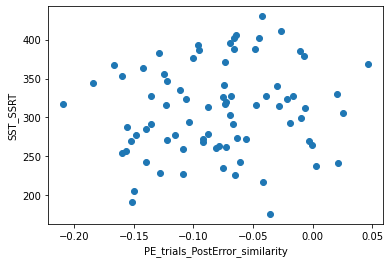

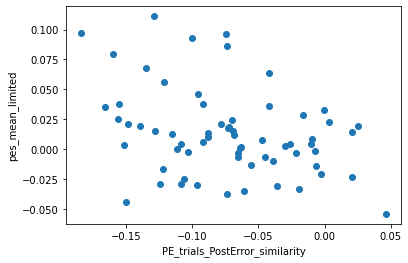

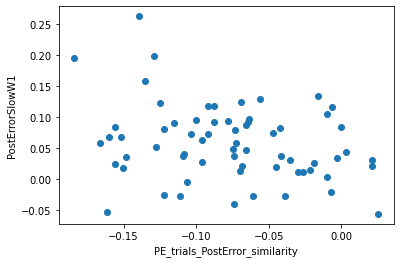

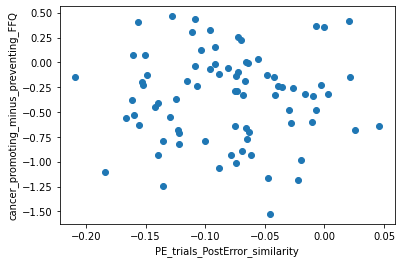

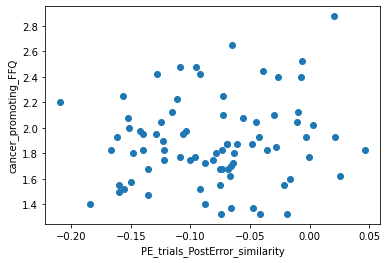

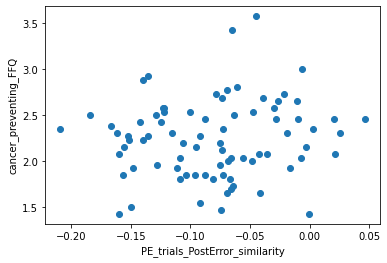

### PC_trials_PostCorrect_similarity

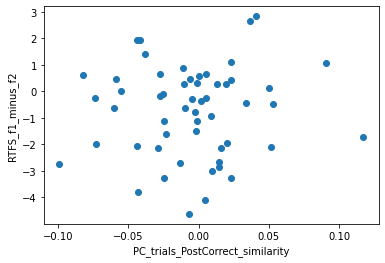

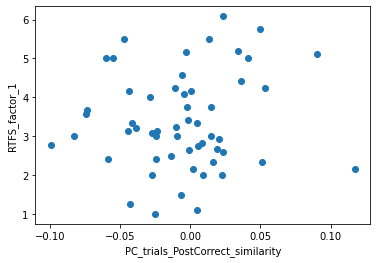

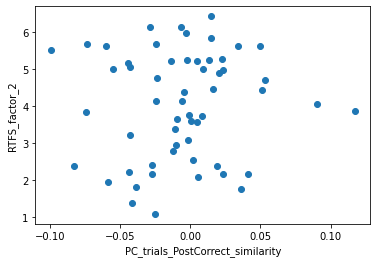

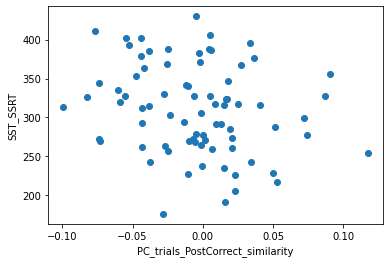

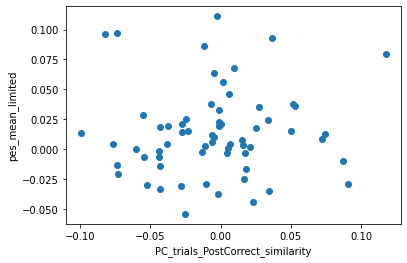

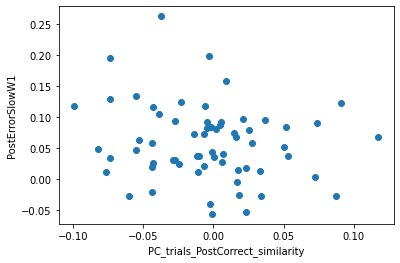

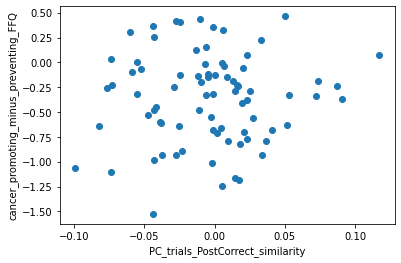

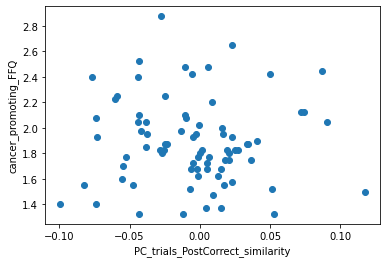

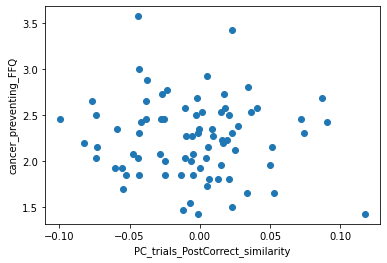

In [55]:

for neural_var in ['PE_trials_PostError_similarity','PC_trials_PostCorrect_similarity']:
    display(Markdown("### " + neural_var))
    for correlate in ['RTFS_f1_minus_f2','RTFS_factor_1','RTFS_factor_2','SST_SSRT','pes_mean_limited','PostErrorSlowW1','cancer_promoting_minus_preventing_FFQ',
        'cancer_promoting_FFQ','cancer_preventing_FFQ']:
        visualize_corr(neural_var,correlate,ind_div_combined)


### Male

#### PE_trials_PostError_similarity

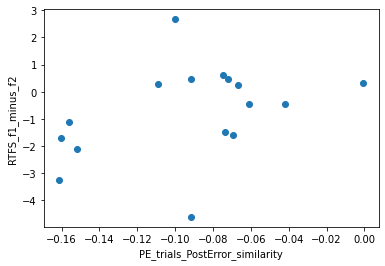

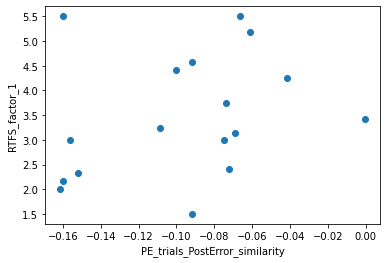

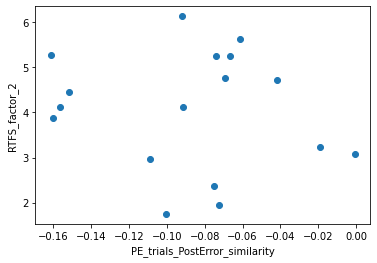

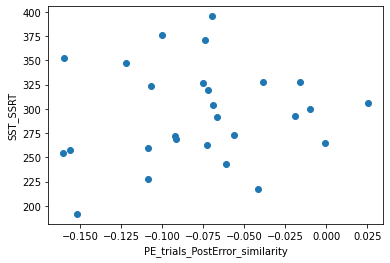

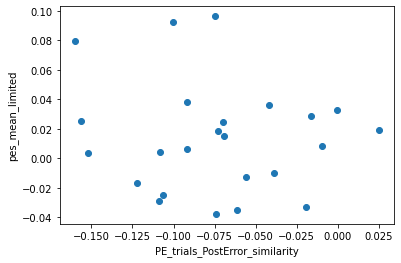

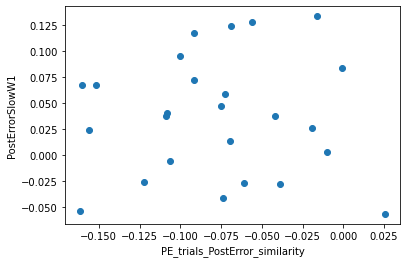

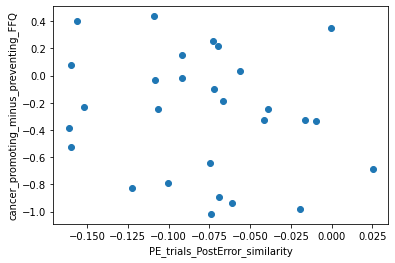

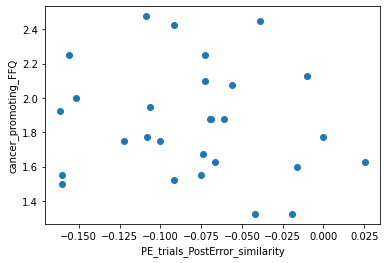

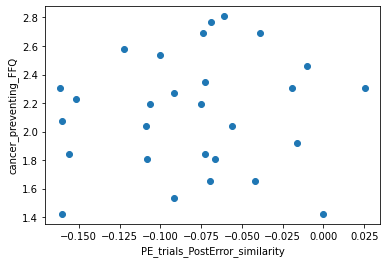

#### PC_trials_PostCorrect_similarity

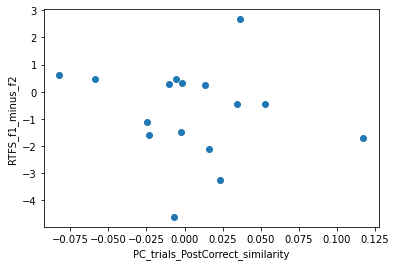

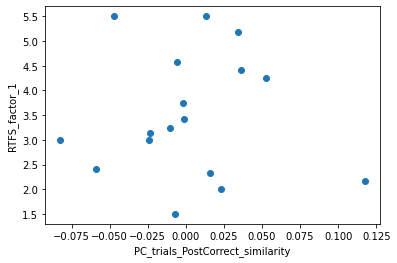

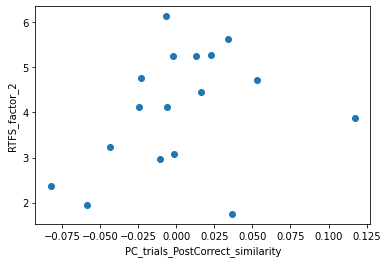

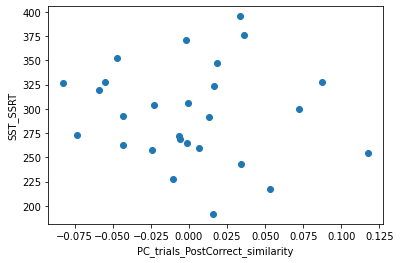

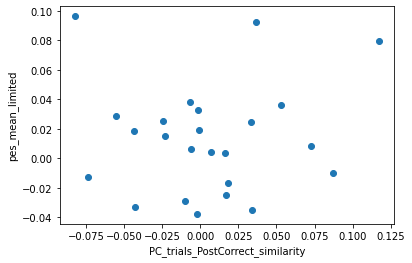

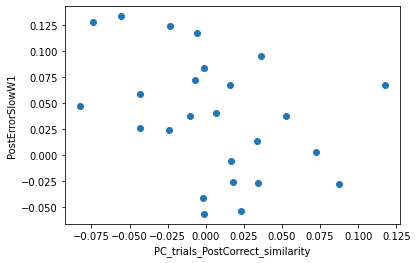

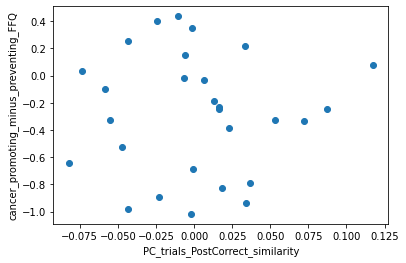

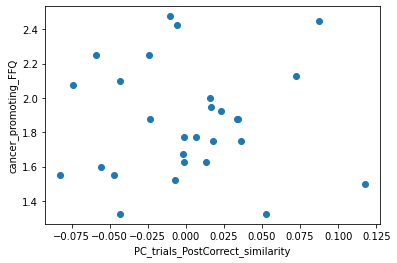

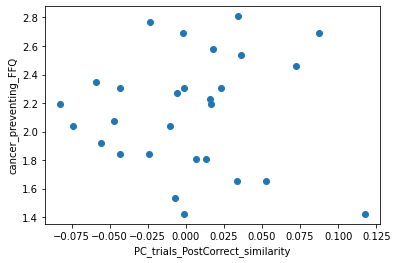

### Female

#### PE_trials_PostError_similarity

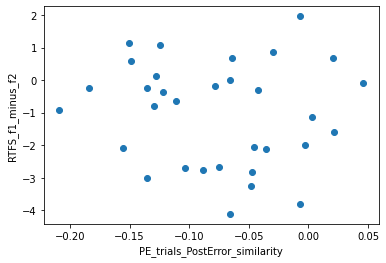

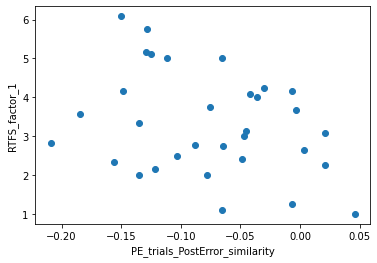

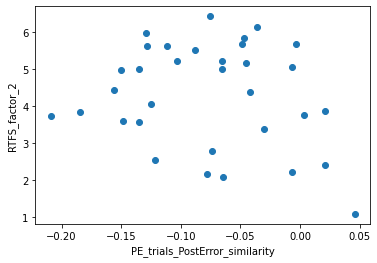

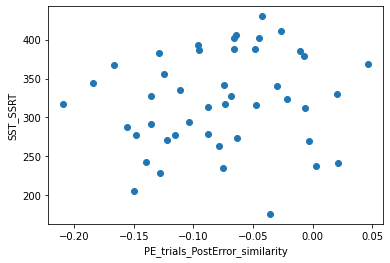

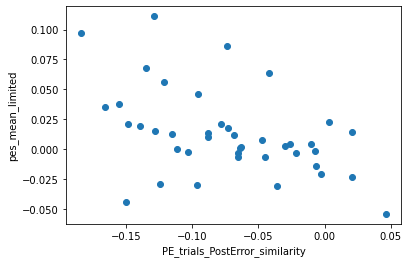

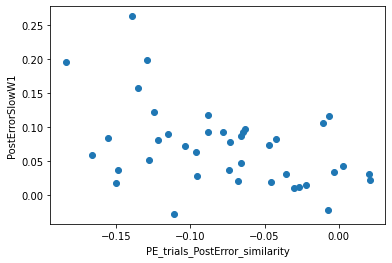

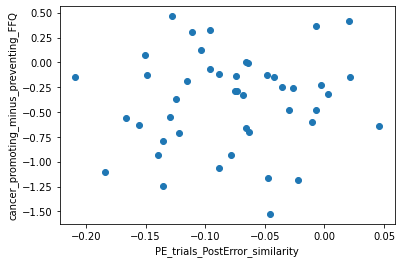

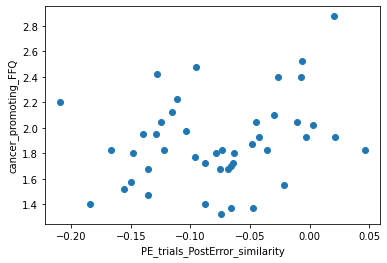

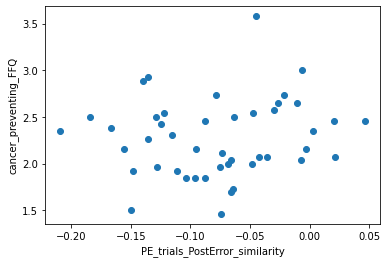

#### PC_trials_PostCorrect_similarity

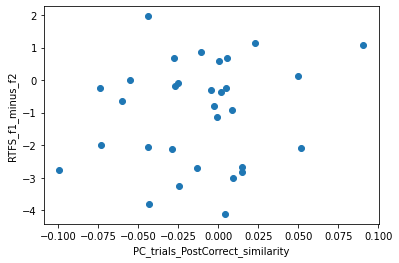

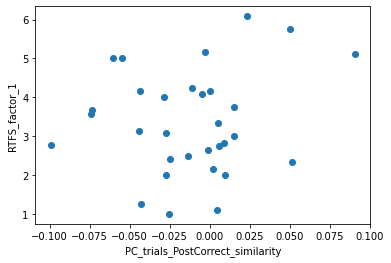

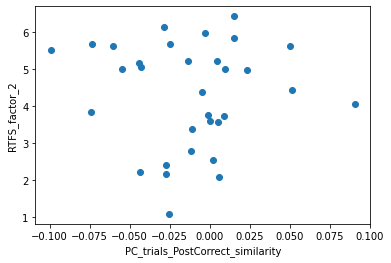

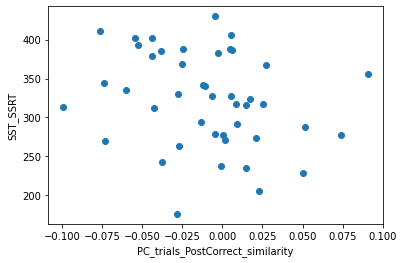

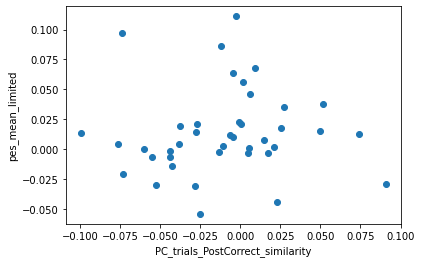

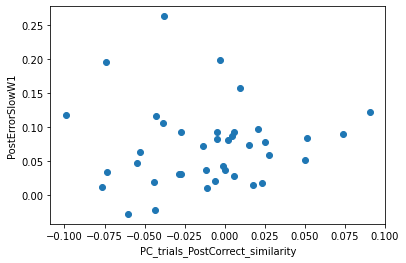

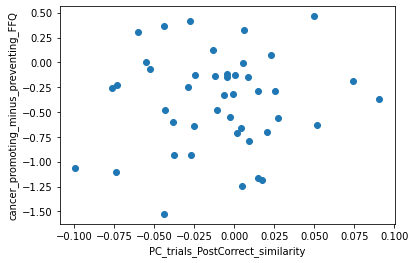

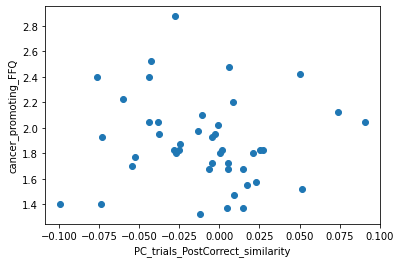

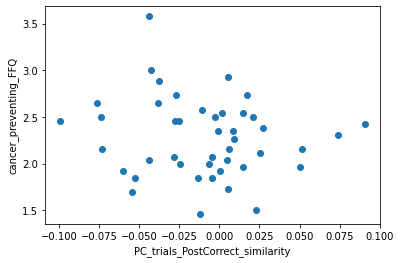

In [56]:

if include_gender_breakdown:
    for bs_f in ['Male','Female']:
        display(Markdown("### " + bs_f))
        for neural_var in ['PE_trials_PostError_similarity','PC_trials_PostCorrect_similarity']:
            display(Markdown("#### " + neural_var))
            for correlate in ['RTFS_f1_minus_f2','RTFS_factor_1','RTFS_factor_2','SST_SSRT','pes_mean_limited','PostErrorSlowW1','cancer_promoting_minus_preventing_FFQ',
        'cancer_promoting_FFQ','cancer_preventing_FFQ']:
                visualize_corr(neural_var,correlate,ind_div_combined.loc[ind_div_combined.birthsex_factor==bs_f,:].reset_index(drop=True))




RTFS is very close. let's just wait and see how things work out once we've tried all the other stuff.

#### What could we do to improve these results?

 - re-do the work above to do stats on contrasts of stop vs. go rather than each separately
     - we tried this. above in the "image contrast" section. Maybe helped but I don't think so. Repeated in `PES-RTFS-analyze-wholebrain` but this didn't help.
 - Most look more or less normal. There are a few outliers but I don't think we have any justification for trimming them out.
 - We need to revise the SSRT and PES scores to make sure they're configured correctly.
     - Probably should stick with wave 1 scores becasue these are from the very same run as the neural analysis.
     - yes these are correct--confirmed!
 - We need to make sure we have all the subjects included we want to include and only those we want to include. I haven't quite decided about this. The pre-registration specifically included data collected up to a certain date (August 16?) - do we want that set or do we have another set?
 - How do we split training and validation subjects up
     - still doing 50-50 here. would be useful to get more power, but on the other hand, would like to save some power for a validation set.
 - For the post-error contrast, would we benefit from contrasting each post-error trial with its pre-error trial? I think that additional contrast would give us an extra level of control. However, we'd probably be moving away from the whole-task-beta approach we've been using now.
 - We might further consider what the appropriate region of interest is. However, I think we've set them appropriately
     - something related to rumination? dlPFC? vmPFC? resting state pattern? 'rumination' keyword?
 - Could use the neurosynth images as neural signatures rather than binary masks
     - ask Dasa about thsi but I don't think that works. our classifier should already identify most important areas within the mask and scale them appropriately. we won't add anything further by telling it to overweight specific voxels.
 - dot product instead of correlation
     - seems to marginally help a little bit. worth doing.

In summary, the best run so far is whole-brain, `dot_product` similarity, female subjects only. Going to a single-contrast doesn't help. Haven't tried using the neurosynth images as multiplicative signatures but not sure that would help.

No particular region seems to yield useful results, which will complicate interpretation.

Should probably look at that one across all the data.

### PE_trials_PostError_similarity

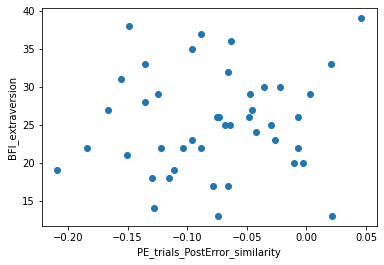

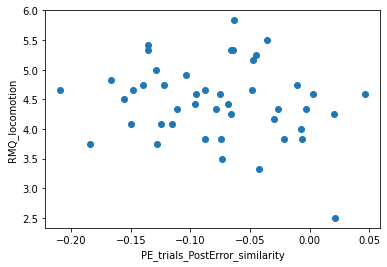

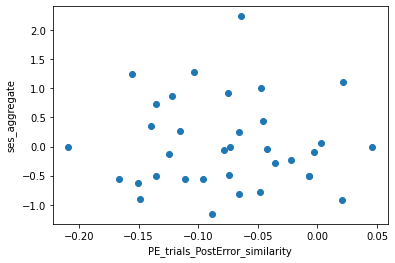

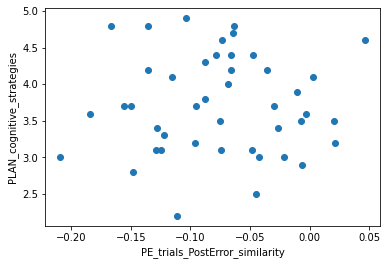

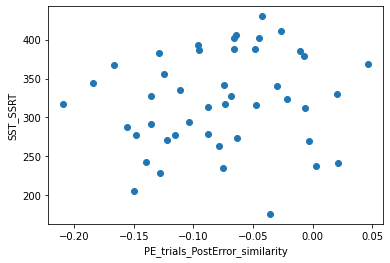

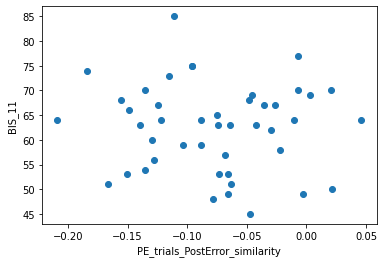

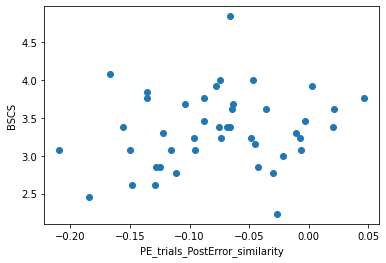

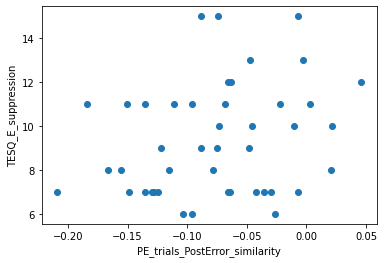

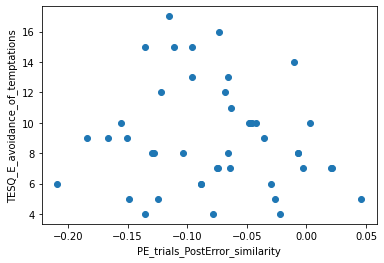

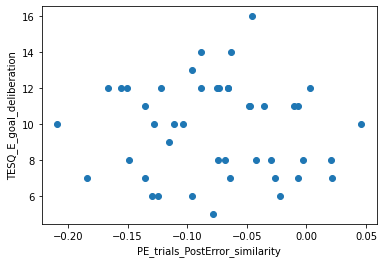

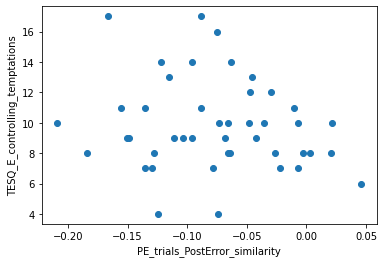

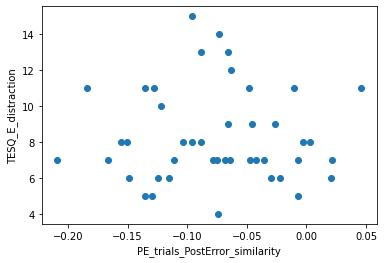

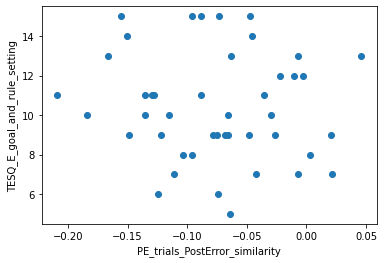

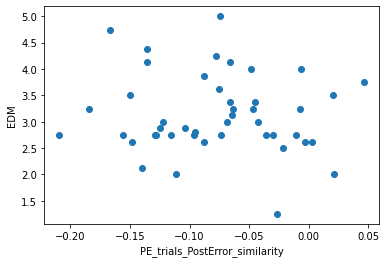

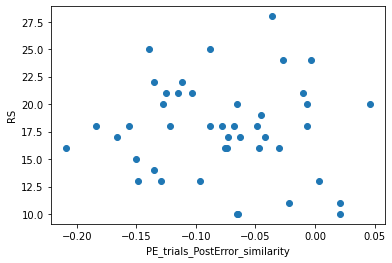

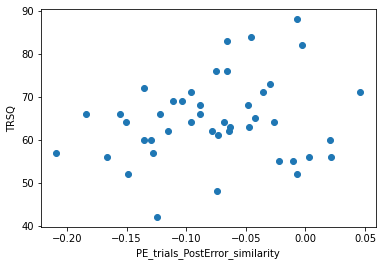

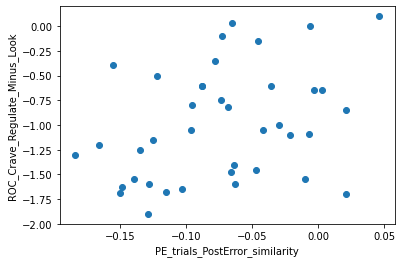

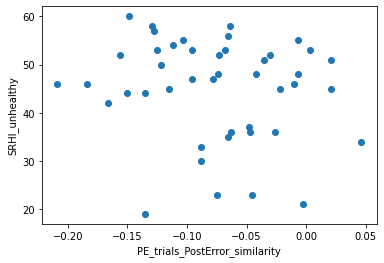

### PC_trials_PostCorrect_similarity

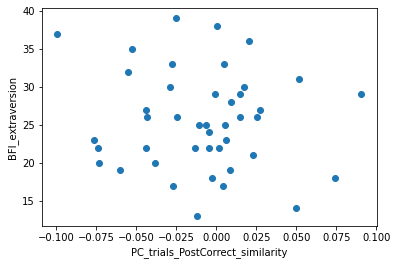

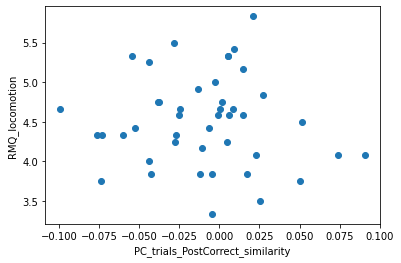

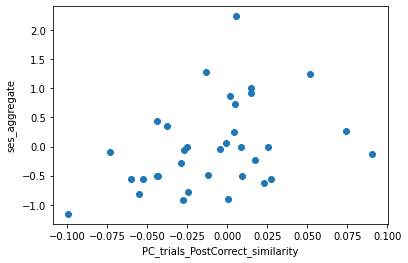

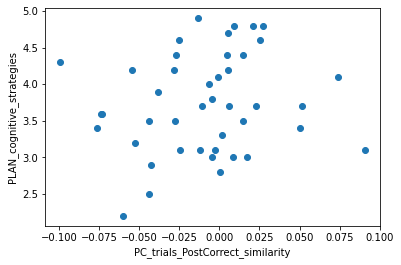

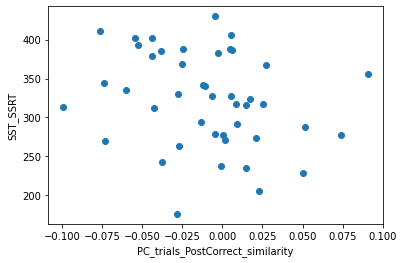

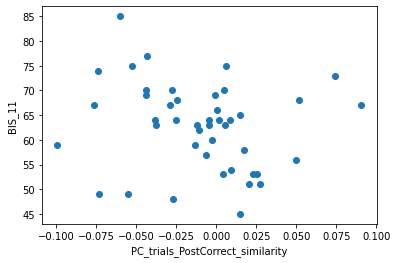

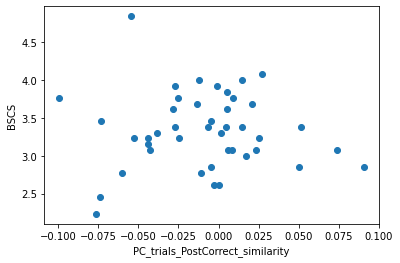

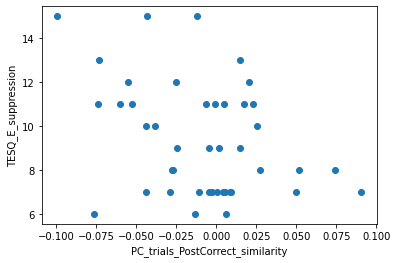

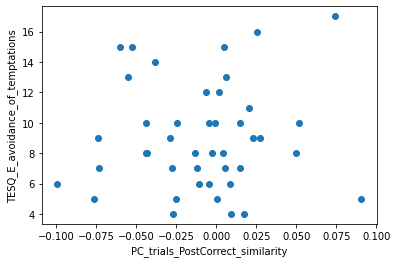

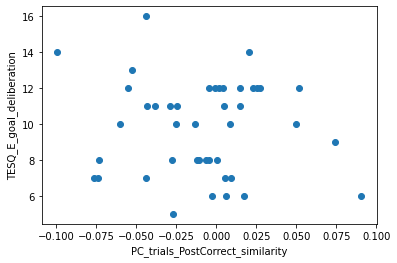

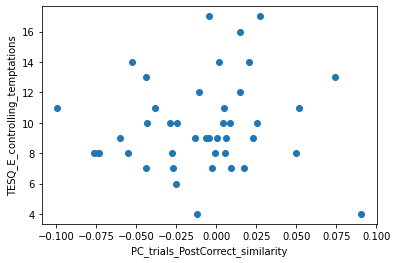

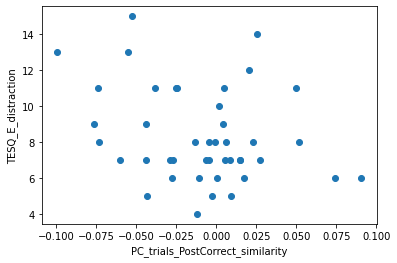

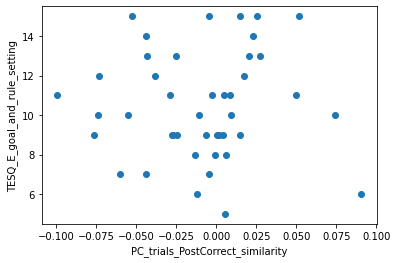

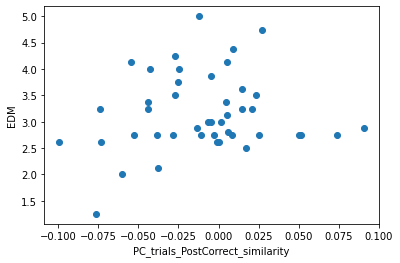

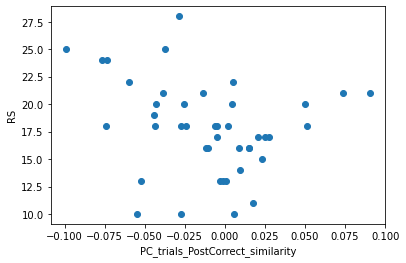

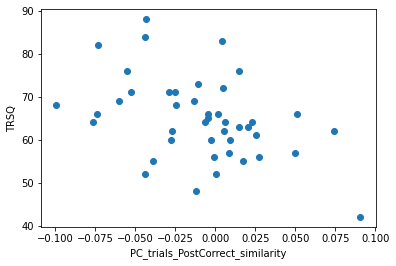

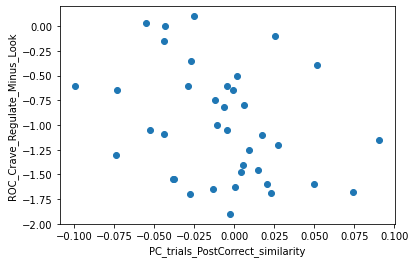

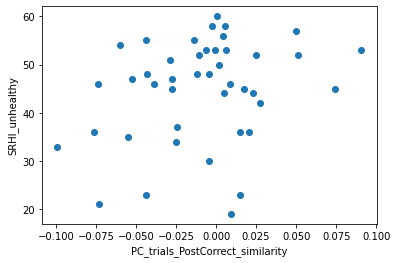

In [57]:
#Other variables
for neural_var in ['PE_trials_PostError_similarity','PC_trials_PostCorrect_similarity']:
    display(Markdown("### " + neural_var))
    for correlate in ['BFI_extraversion','RMQ_locomotion','ses_aggregate','PLAN_cognitive_strategies','SST_SSRT','BIS_11','BSCS','TESQ_E_suppression', 'TESQ_E_avoidance_of_temptations', 
                      'TESQ_E_goal_deliberation', 'TESQ_E_controlling_temptations', 'TESQ_E_distraction', 'TESQ_E_goal_and_rule_setting',
                     'EDM','RS','TRSQ','ROC_Crave_Regulate_Minus_Look','SRHI_unhealthy']:
        visualize_corr(neural_var,correlate,ind_div_combined.loc[ind_div_combined.birthsex_factor=='Female',:].reset_index(drop=True))


There's something interesting in Female subjects for TRSQ. Nothing with RTFS though.

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_wholebrain.pkl
0.8888888888888888
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_posterror_conditions_84subs_twoclasses_wholebrain.pkl
plotting signatures


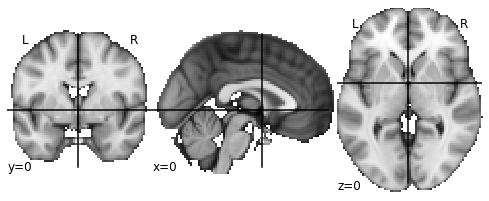

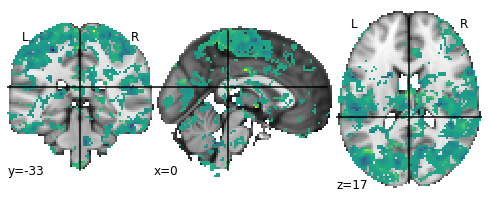

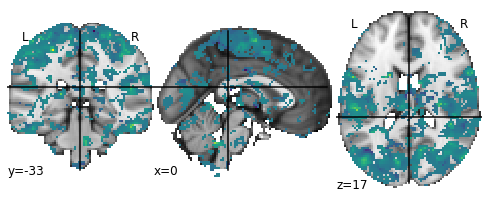

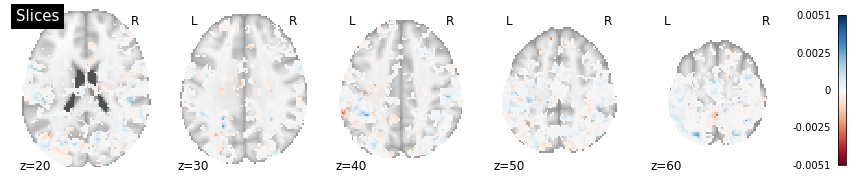

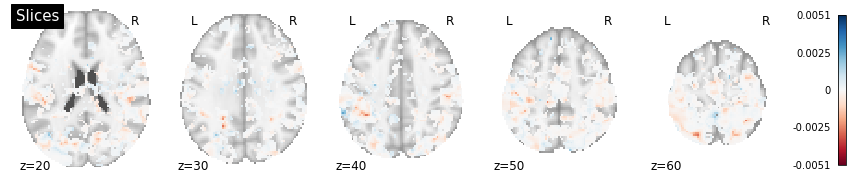

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


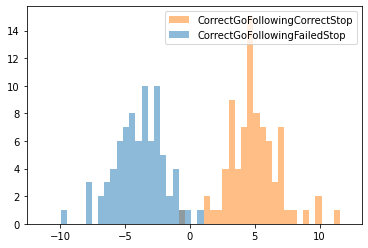

0.009232456815562565 0.07499674494725306 -0.0657642881316905 0.08422920176281562


0.04934769830378225 0.16000871055522017 -0.11066101225143793 0.20935640885900242


1200.7835177866666 4461.633046351562 -3260.849528564896 5662.416564138229


4.872617978045989 5.159237045882512 -0.286619067836523 10.0318550239285


-3.8214337347524667 5.6639886574443405 -9.485422392196806 1.8425549226918738


-4.872617978045989 5.159237045882512 -10.0318550239285 0.286619067836523


3.8214337347524667 5.6639886574443405 -1.8425549226918738 9.485422392196806


### PE_trials_PostError_similarity

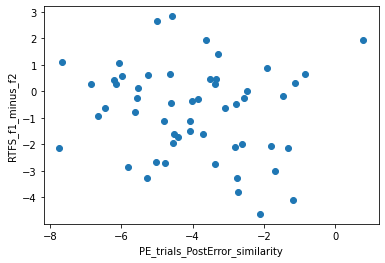

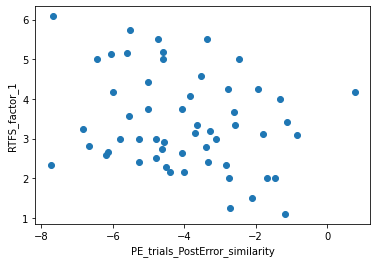

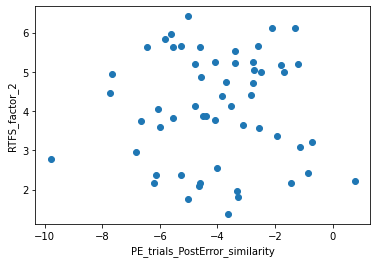

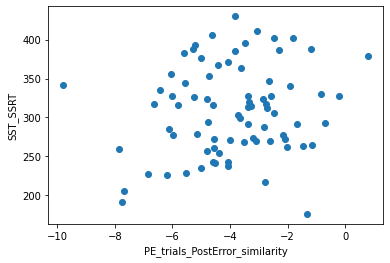

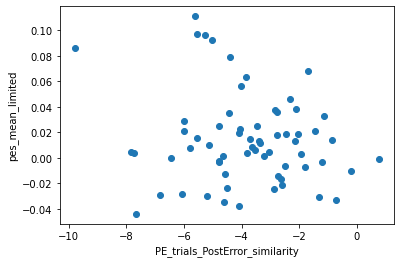

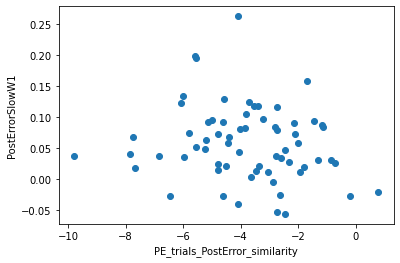

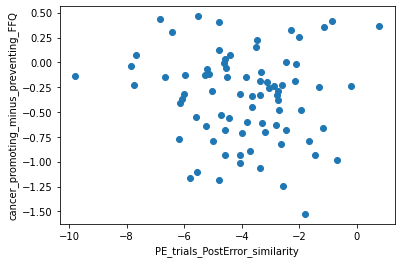

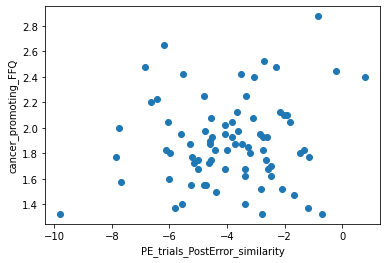

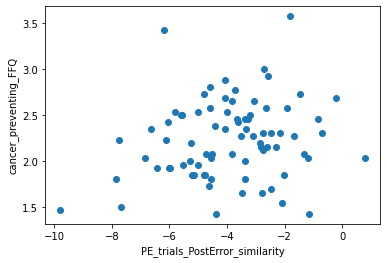

### PC_trials_PostCorrect_similarity

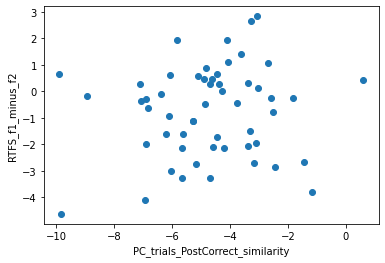

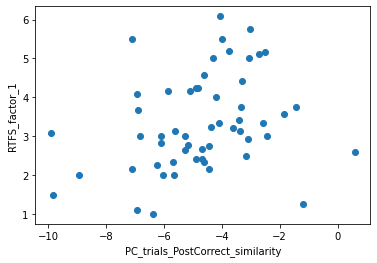

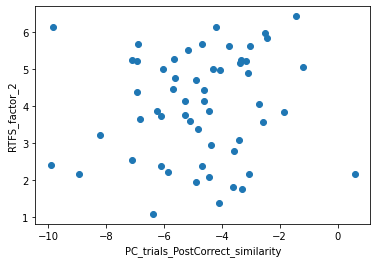

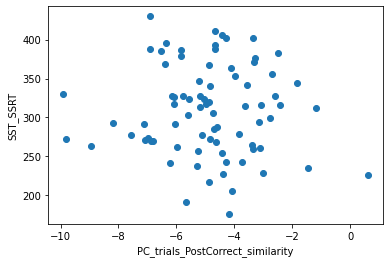

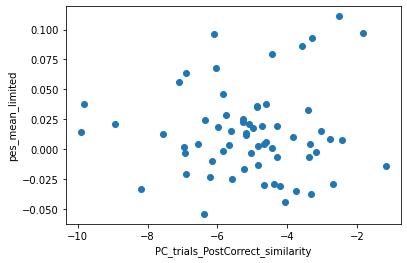

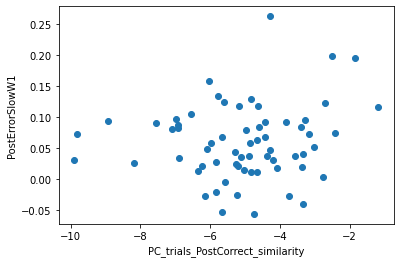

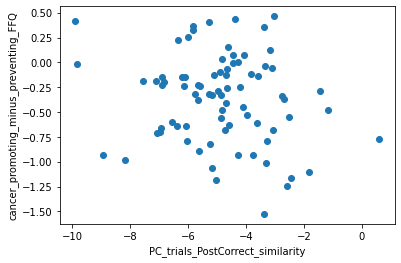

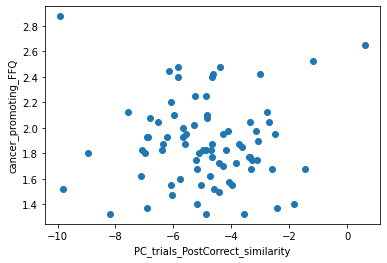

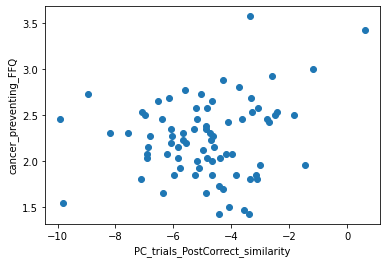

### Male

#### CS_trials_CS_similarity

KeyError: 'CS_trials_CS_similarity'

In [58]:
run_full_pes_analysis('wholebrain',None,'dot_product',include_gender_breakdown=True)